### start

In [43]:
# pyright: reportMissingImports=false
# pyright: reportMissingModuleSource=false

import uuid
import random
import hashlib
import os
import sys
import gc
import time
import copy
import logging
import re
from itertools import chain,combinations
import pdb
import math
from pathlib import Path
import datetime
from datetime import datetime,timedelta
import json
import warnings
import yaml
from typing import Dict,Union,List,Any,Tuple
import pytest
import importlib
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import IPython
import requests
import warnings
import boto3
import matplotlib as plt
import sklearn

# load_dotenv(Path("../../../Local/.env"))

# Custom format function for displaying |numbers/
pd.set_option('display.float_format', lambda x: f'{x:.12g}')
# pd.reset_option('display.float_format')

# Suppress warnings
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
warnings.filterwarnings('ignore', message='.*frozen modules.*')
warnings.filterwarnings("ignore", message="MallocStackLogging")

# silence pygame donation request
os.environ['PYGAME_HIDE_SUPPORT_PROMPT'] = "hide"
os.environ['LOGGING_FILE'] = "../../../Local/logs/wallet_modeling.log"
os.environ['NOTIFICATION_SOUNDS_DIR'] = "../../../Local"

# Dark mode charts
plt.rcParams['figure.facecolor'] = '#181818'  # Custom background color (dark gray in this case)
plt.rcParams['axes.facecolor'] = '#181818'
plt.rcParams['text.color'] = '#afc6ba'
plt.rcParams['axes.labelcolor'] = '#afc6ba'
plt.rcParams['xtick.color'] = '#afc6ba'
plt.rcParams['ytick.color'] = '#afc6ba'
plt.rcParams['axes.titlecolor'] = '#afc6ba'
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'

# import local modules
# pyright: reportMissingImports=false
sys.path.append('../src')

import sage_utils.config_validation as ucv
import sage_utils.s3_utils as s3u

import sage_wallet_insights.evaluation_orchestrator as eo
import sage_wallet_insights.model_evaluation as sime

import sage_wallet_modeling.wallet_modeler as wm
from sage_wallet_modeling.wallet_preprocessor import SageWalletsPreprocessor
import sage_wallet_modeling.wallet_script_modeler as sm
import sage_wallet_modeling.workflow_orchestrator as wo

import script_modeling.entry_helpers as h
# import script_modeling.temporal_cv_model_entry as tme


# import data-science modules
sys.path.append(str(Path("..") / ".." / "data-science" / "src"))
import wallet_insights.model_evaluation as wime
import wallet_insights.wallet_validation_analysis as wiva
import utils as u
from utils import ConfigError



# reload all modules
modules = [
    ucv, s3u,
    eo, sime,
    wm, sm, wo,
    h,
    wime, wiva,
    u,
]

# import utils as u
# Set the custom error handler
ipython = IPython.get_ipython()
# ipython.set_custom_exc((Exception,), u.notify_on_failure)

player = u.AmbientPlayer()
player.stop_all_players()

# configure logger
logger = u.setup_notebook_logger('../logs/notebook_logs.log')
logger.setLevel(logging.INFO)

from IPython.core import ultratb
ultratb.VerboseTB._tb_highlight = "bg:#b45827"


# load all configs
sage_wallets_config = ucv.load_sage_wallets_config(Path('../config/sage_wallets_config.yaml'))
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config(Path('../config/sage_wallets_modeling_config.yaml'))


u.export_code(
    code_directories=[
        # 'config_models',
        'sage_wallet_insights',
        'sage_wallet_modeling',
        'script_modeling',
        # 'sage_utils',
    ],
    # include_config = True,
    # ipynb_notebook = 'DDA-769 coin model score dist toggle.ipynb'
    output_file="temp/sagemaker_code.py"
)

[importlib.reload(module) for module in modules]
u.notify('retro')

logger.milestone("Good morning, let's get to work")

[13/Aug/25 12:53:40] INFO [utils.export_code:1672] Consolidation complete. All files are saved in temp/sagemaker_code.py
[13/Aug/25 12:53:40] MILESTONE [2680403529.<module>:138] Good morning, let's get to work


# Model Training

## Concatenated Model Sequence

#### load all local data

In [9]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
workflow_orch.load_all_training_data()

[11/Aug/25 23:43:52] INFO [workflow_orchestrator.load_all_training_data:101] Auto-detected date_suffixes from config: ['210322', '210421', '210521', '210620', '210720', '210819', '210918', '211018', '211117', '211217', '220116', '220215', '220317', '220416', '220516', '220615', '220715', '220814', '220913', '221013', '221112', '221212', '230111', '230210', '230312', '230411', '230511', '230610', '230710', '230809', '230908', '231008', '231107', '231207', '240106', '240205', '240306', '240405', '240505', '240604', '240704', '240803', '241002', '241201', '250130', '250331', '240902', '241101', '241231', '250301', '250430', '250530']
[11/Aug/25 23:43:52] MILESTONE [workflow_orchestrator.load_all_training_data:118] <PROD> Loading training data for 52 periods: ['210322', '210421', '210521', '210620', '210720', '210819', '210918', '211018', '211117', '211217', '220116', '220215', '220317', '220416', '220516', '220615', '220715', '220814', '220913', '221013', '221112', '221212', '230111', '23

#### preprocess and concatenate

In [10]:
results = workflow_orch.preprocess_all_training_data()

[11/Aug/25 23:44:00] INFO [workflow_orchestrator.preprocess_all_training_data:156] Preprocessing 52 date periods...
[11/Aug/25 23:44:00] INFO [wallet_preprocessor.preprocess_training_data:74] Starting preprocessing for SageMaker XGBoost compatibility...
[11/Aug/25 23:44:00] INFO [wallet_preprocessor._handle_missing_values:243] Filled NaN values in 110 columns for x_train.
[11/Aug/25 23:44:00] INFO [wallet_preprocessor._save_preprocessed_df:418] Saved preprocessed train to ../s3_uploads/wallet_training_data_preprocessed/dda_957_coin_model/210322/train.parquet
[11/Aug/25 23:44:00] INFO [wallet_preprocessor._save_preprocessed_df:418] Saved preprocessed train_y to ../s3_uploads/wallet_training_data_preprocessed/dda_957_coin_model/210322/train_y.parquet
[11/Aug/25 23:44:00] INFO [wallet_preprocessor.preprocess_training_data:123] Preprocessed train: 60,736 rows × 231 cols.
[11/Aug/25 23:44:00] INFO [wallet_preprocessor._handle_missing_values:243] Filled NaN values in 110 columns for x_test.


In [11]:
workflow_orch.concatenate_all_preprocessed_data()

[11/Aug/25 23:44:39] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:194] Loading preprocessed training data...
[11/Aug/25 23:44:43] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:197] Beginning concatenation of preprocessed data from Parquet...
[11/Aug/25 23:44:44] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:260] Saved concatenated train_index.parquet with 1148070 rows to ../s3_uploads/wallet_training_data_concatenated/dda_957_coin_model/train_index.parquet
[11/Aug/25 23:50:10] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:267] Saved concatenated train.csv.gz with 1148070 rows to ../s3_uploads/wallet_training_data_concatenated/dda_957_coin_model/train.csv.gz
[11/Aug/25 23:50:10] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:260] Saved concatenated eval_index.parquet with 44811 rows to ../s3_uploads/wallet_training_data_concatenated/dda_957_coin_model/eval_index.parquet
[11/Aug/25 23:50:22] INFO [workflow_or

#### inspect features

In [ ]:
local_s3 = sage_wallets_config['training_data']['local_s3_root']
local_dir = sage_wallets_config['training_data']['local_directory']
local_dir = f"{local_dir}_dev" if sage_wallets_config['training_data']['dataset'] == 'dev' else local_dir
df = pd.read_csv(f'{local_s3}/s3_uploads/wallet_training_data_concatenated/{local_dir}/eval.csv')
with open(f'{local_s3}/s3_uploads/wallet_training_data_concatenated/{local_dir}/metadata.json', 'r') as f:
    metadata = json.load(f)

df.columns = metadata['feature_columns']
u.display_full(df.describe().T)

#### upload

In [12]:
concat_uris = workflow_orch.upload_concatenated_training_data(
    overwrite_existing=True,
    # splits=['val']
)

[11/Aug/25 23:54:34] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials
[11/Aug/25 23:54:34] INFO [workflow_orchestrator.upload_concatenated_training_data:380] Beginning upload of concatenated training data for splits ['train', 'eval', 'test', 'val', 'train_y', 'eval_y', 'test_y', 'val_y']...
[11/Aug/25 23:54:34] INFO [workflow_orchestrator.upload_concatenated_training_data:383] Uploading concatenated splits in parallel with 4 threads...
[11/Aug/25 23:54:34] INFO [workflow_orchestrator._upload_split:401] Overwriting existing file 's3://wallet-training-data/training-data-concatenated/dda-957-coin-model/train.csv.gz'...
[11/Aug/25 23:54:34] INFO [workflow_orchestrator._upload_split:401] Overwriting existing file 's3://wallet-training-data/training-data-concatenated/dda-957-coin-model/val.csv.gz'...
[11/Aug/25 23:54:34] INFO [workflow_orchestrator._upload_split:401] Overwriting existing file 's3://wallet-training-data/training-data-concatenated/d

### Epoch Shifts Sequence

#### train all epoch shifts

In [31]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
concat_uris = workflow_orch.upload_concatenated_training_data(overwrite_existing=False)
modeling_results = workflow_orch.train_all_epoch_shift_models(concat_uris)

[13/Aug/25 12:06:05] INFO [workflow_orchestrator.upload_concatenated_training_data:383] Beginning upload of concatenated training data for splits ['train', 'eval', 'test', 'val', 'train_y', 'eval_y', 'test_y', 'val_y']...
[13/Aug/25 12:06:05] INFO [workflow_orchestrator.upload_concatenated_training_data:386] Uploading concatenated splits in parallel with 4 threads...


[13/Aug/25 12:06:05] INFO [workflow_orchestrator._upload_split:400] File exists, skipping upload of concatenated split 'test': training-data-concatenated/dda-956-importance/test.csv.gz
[13/Aug/25 12:06:05] INFO [workflow_orchestrator._upload_split:400] File exists, skipping upload of concatenated split 'eval': training-data-concatenated/dda-956-importance/eval.csv.gz
[13/Aug/25 12:06:05] INFO [workflow_orchestrator._upload_split:400] File exists, skipping upload of concatenated split 'val': training-data-concatenated/dda-956-importance/val.csv.gz
[13/Aug/25 12:06:05] INFO [workflow_orchestrator._upload_split:400] File exists, skipping upload of concatenated split 'train': training-data-concatenated/dda-956-importance/train.csv.gz
[13/Aug/25 12:06:05] INFO [workflow_orchestrator._upload_split:400] File exists, skipping upload of concatenated split 'train_y': training-data-concatenated/dda-956-importance/train_y.csv
[13/Aug/25 12:06:05] INFO [workflow_orchestrator._upload_split:400] File

2025-08-13 19:06:07 Starting - Starting the training job2025-08-13 19:06:11 Starting - Starting the training job2025-08-13 19:06:07 Starting - Starting the training job2025-08-13 19:06:07 Starting - Starting the training job....2025-08-13 19:06:13 Starting - Starting the training job.2025-08-13 19:06:09 Starting - Starting the training job2025-08-13 19:06:09 Starting - Starting the training job..2025-08-13 19:06:10 Starting - Starting the training job.2025-08-13 19:06:12 Starting - Starting the training job.2025-08-13 19:06:13 Starting - Starting the training job.2025-08-13 19:06:15 Starting - Starting the training job.2025-08-13 19:06:17 Starting - Starting the training job........................

[13/Aug/25 12:06:39] INFO [workflow_orchestrator._train_single_epoch_shift:1060] Starting training for epoch_shift=0
[13/Aug/25 12:06:39] INFO [wallet_script_modeler.initiate_script_modeling:57] HPO disabled for sh0, using standard training...
[13/Aug/25 12:06:39] INFO [image_uris._validate_py_version_and_set_if_needed:603] Ignoring unnecessary Python version: py3.
[13/Aug/25 12:06:39] INFO [image_uris._processor:530] Ignoring unnecessary instance type: ml.m6i.2xlarge.
[13/Aug/25 12:06:39] INFO [wallet_script_modeler._train_single_period_script_model:142] Launching script-mode training job with custom targets: wscr-dda-956--sh0-0813-120639
[13/Aug/25 12:06:39] INFO [telemetry_logging.wrapper:92] SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs

.
2025-08-13 19:06:39 Starting - Preparing the instances for training
2025-08-13 19:06:42 Downloading - Downloading input data
2025-08-13 19:06:42 Starting - Preparing the instances for training....
2025-08-13 19:06:30 Starting - Preparing the instances for training.2025-08-13 19:06:40 Starting - Starting the training job...
2025-08-13 19:06:38 Starting - Preparing the instances for training.
2025-08-13 19:06:37 Starting - Preparing the instances for training.
2025-08-13 19:06:45 Starting - Preparing the instances for training.
2025-08-13 19:06:29 Starting - Preparing the instances for training.
2025-08-13 19:06:47 Downloading - Downloading input data...........................
2025-08-13 19:06:55 Downloading - Downloading input data
2025-08-13 19:07:09 Starting - Preparing the instances for training
2025-08-13 19:06:58 Downloading - Downloading input data....
2025-08-13 19:06:50 Downloading - Downloading input data.
2025-08-13 19:07:09 Downloading - Downloading input data
2025-08-13 1

[13/Aug/25 12:12:33] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh-300/wscr-dda-956--sh-300-0813-120606/output/model.tar.gz
[13/Aug/25 12:12:33] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=-300


[131]#011eval-aucpr:0.58825
[132]#011eval-aucpr:0.58971
[133]#011eval-aucpr:0.58990
[134]#011eval-aucpr:0.59127
[135]#011eval-aucpr:0.59141
[136]#011eval-aucpr:0.59154
[137]#011eval-aucpr:0.59289
[138]#011eval-aucpr:0.59366
[139]#011eval-aucpr:0.59405
[140]#011eval-aucpr:0.59389
[141]#011eval-aucpr:0.59391
[142]#011eval-aucpr:0.59392
[124]#011eval-aucpr:0.24229
[125]#011eval-aucpr:0.24303
[126]#011eval-aucpr:0.24409
[127]#011eval-aucpr:0.24323
[128]#011eval-aucpr:0.24030
[129]#011eval-aucpr:0.24011
[130]#011eval-aucpr:0.23918
[131]#011eval-aucpr:0.24031
[132]#011eval-aucpr:0.24213
[133]#011eval-aucpr:0.24241
[134]#011eval-aucpr:0.24540
[135]#011eval-aucpr:0.24673
[136]#011eval-aucpr:0.24655
[137]#011eval-aucpr:0.24663
[117]#011eval-aucpr:0.47827
[118]#011eval-aucpr:0.48030
[119]#011eval-aucpr:0.48071
[120]#011eval-aucpr:0.48083
[121]#011eval-aucpr:0.48095
[122]#011eval-aucpr:0.48138
[123]#011eval-aucpr:0.48270
[124]#011eval-aucpr:0.48256
[125]#011eval-aucpr:0.48307
[126]#011eval-aucpr:

[13/Aug/25 12:13:12] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh240/wscr-dda-956--sh240-0813-120606/output/model.tar.gz
[13/Aug/25 12:13:12] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=240


[184]#011eval-aucpr:0.60702
[185]#011eval-aucpr:0.60706
[186]#011eval-aucpr:0.60792
[187]#011eval-aucpr:0.60840
[188]#011eval-aucpr:0.61008
[189]#011eval-aucpr:0.61086
[179]#011eval-aucpr:0.31556
[180]#011eval-aucpr:0.31595
[181]#011eval-aucpr:0.31644
[182]#011eval-aucpr:0.31684
[183]#011eval-aucpr:0.31709
[184]#011eval-aucpr:0.31702
[185]#011eval-aucpr:0.31719
[186]#011eval-aucpr:0.31711
[187]#011eval-aucpr:0.31733
[188]#011eval-aucpr:0.31756
[189]#011eval-aucpr:0.31752
[190]#011eval-aucpr:0.31767
[180]#011eval-aucpr:0.25782
[181]#011eval-aucpr:0.25833
[182]#011eval-aucpr:0.25851
[183]#011eval-aucpr:0.25817
[184]#011eval-aucpr:0.25824
[185]#011eval-aucpr:0.25792
[186]#011eval-aucpr:0.25835
[187]#011eval-aucpr:0.25881
[188]#011eval-aucpr:0.25773
[189]#011eval-aucpr:0.25763
[190]#011eval-aucpr:0.25722
[191]#011eval-aucpr:0.25755
[192]#011eval-aucpr:0.25665
[127]#011eval-aucpr:0.39389
[128]#011eval-aucpr:0.39820
[129]#011eval-aucpr:0.39897
[130]#011eval-aucpr:0.40064
[131]#011eval-aucpr:

[13/Aug/25 12:14:41] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh-240/wscr-dda-956--sh-240-0813-120606/output/model.tar.gz
[13/Aug/25 12:14:41] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=-240


[232]#011eval-aucpr:0.51554
[233]#011eval-aucpr:0.51616
[234]#011eval-aucpr:0.51597
[235]#011eval-aucpr:0.51637
[236]#011eval-aucpr:0.51637
[237]#011eval-aucpr:0.51636
[238]#011eval-aucpr:0.51637
[239]#011eval-aucpr:0.51657
[240]#011eval-aucpr:0.51635
[241]#011eval-aucpr:0.51684
Training seconds: 436
Billable seconds: 436


[13/Aug/25 12:14:43] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh360/wscr-dda-956--sh360-0813-120606/output/model.tar.gz
[13/Aug/25 12:14:43] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=360


[219]#011eval-aucpr:0.52813
[220]#011eval-aucpr:0.52831
[221]#011eval-aucpr:0.52776
[222]#011eval-aucpr:0.52829
[223]#011eval-aucpr:0.52907
[224]#011eval-aucpr:0.53055
[225]#011eval-aucpr:0.53099
[226]#011eval-aucpr:0.53073
[227]#011eval-aucpr:0.53070
[228]#011eval-aucpr:0.53094
[229]#011eval-aucpr:0.53170
[253]#011eval-aucpr:0.48452
[254]#011eval-aucpr:0.48474
[255]#011eval-aucpr:0.48494
[256]#011eval-aucpr:0.48453
[257]#011eval-aucpr:0.48424
[258]#011eval-aucpr:0.48465
[259]#011eval-aucpr:0.48471
[260]#011eval-aucpr:0.48466
[261]#011eval-aucpr:0.48482
[262]#011eval-aucpr:0.48530
[263]#011eval-aucpr:0.48560
[264]#011eval-aucpr:0.48589
[265]#011eval-aucpr:0.48612
[266]#011eval-aucpr:0.48603
[267]#011eval-aucpr:0.48620
[268]#011eval-aucpr:0.48607
[269]#011eval-aucpr:0.48580
Training seconds: 441
Billable seconds: 441


[13/Aug/25 12:14:46] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh-180/wscr-dda-956--sh-180-0813-120606/output/model.tar.gz
[13/Aug/25 12:14:46] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=-180


[289]#011eval-aucpr:0.63558
[290]#011eval-aucpr:0.63557
[291]#011eval-aucpr:0.63537
[292]#011eval-aucpr:0.63467
[293]#011eval-aucpr:0.63462
[294]#011eval-aucpr:0.63468
[295]#011eval-aucpr:0.63479
[296]#011eval-aucpr:0.63466
[297]#011eval-aucpr:0.63481
[298]#011eval-aucpr:0.63501
[299]#011eval-aucpr:0.63512
[300]#011eval-aucpr:0.63514
[232]#011eval-aucpr:0.43065
[233]#011eval-aucpr:0.43078
[234]#011eval-aucpr:0.43071
[235]#011eval-aucpr:0.43041
[236]#011eval-aucpr:0.43071
[237]#011eval-aucpr:0.43078
[238]#011eval-aucpr:0.43113
[239]#011eval-aucpr:0.43089
[240]#011eval-aucpr:0.43117
[241]#011eval-aucpr:0.43131
[242]#011eval-aucpr:0.43145
[243]#011eval-aucpr:0.43161
[310]#011eval-aucpr:0.27690
[311]#011eval-aucpr:0.27647
[312]#011eval-aucpr:0.27696
[313]#011eval-aucpr:0.27625
[314]#011eval-aucpr:0.27609
[315]#011eval-aucpr:0.27655
[316]#011eval-aucpr:0.27628
[317]#011eval-aucpr:0.27569
[318]#011eval-aucpr:0.27509
[319]#011eval-aucpr:0.27473
[320]#011eval-aucpr:0.27520
[321]#011eval-aucpr:

[13/Aug/25 12:15:10] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh300/wscr-dda-956--sh300-0813-120606/output/model.tar.gz
[13/Aug/25 12:15:10] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=300
[13/Aug/25 12:15:10] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh120/wscr-dda-956--sh120-0813-120606/output/model.tar.gz
[13/Aug/25 12:15:10] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=120


[263]#011eval-aucpr:0.51942
[264]#011eval-aucpr:0.51873
[265]#011eval-aucpr:0.51876
[266]#011eval-aucpr:0.51889
[267]#011eval-aucpr:0.51880
[268]#011eval-aucpr:0.51888
[269]#011eval-aucpr:0.51877
[270]#011eval-aucpr:0.51831
[271]#011eval-aucpr:0.51900
[272]#011eval-aucpr:0.51940
[252]#011eval-aucpr:0.53901
[253]#011eval-aucpr:0.53901
[254]#011eval-aucpr:0.53944
[255]#011eval-aucpr:0.54017
[256]#011eval-aucpr:0.54047
[257]#011eval-aucpr:0.54111
[258]#011eval-aucpr:0.54100
[259]#011eval-aucpr:0.54056
[260]#011eval-aucpr:0.54061
[261]#011eval-aucpr:0.54053
[262]#011eval-aucpr:0.54066
[293]#011eval-aucpr:0.48758
[294]#011eval-aucpr:0.48755
[295]#011eval-aucpr:0.48740
[296]#011eval-aucpr:0.48756
[297]#011eval-aucpr:0.48750
[298]#011eval-aucpr:0.48761
[299]#011eval-aucpr:0.48769
[300]#011eval-aucpr:0.48759
[301]#011eval-aucpr:0.48771
[302]#011eval-aucpr:0.48847
[303]#011eval-aucpr:0.48846
[304]#011eval-aucpr:0.48839
[324]#011eval-aucpr:0.63754
[325]#011eval-aucpr:0.63731
[326]#011eval-aucpr:

[13/Aug/25 12:15:20] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh-360/wscr-dda-956--sh-360-0813-120606/output/model.tar.gz
[13/Aug/25 12:15:20] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=-360


[273]#011eval-aucpr:0.43393
[274]#011eval-aucpr:0.43382
[275]#011eval-aucpr:0.43453
[276]#011eval-aucpr:0.43533
[277]#011eval-aucpr:0.43527
[278]#011eval-aucpr:0.43437
[279]#011eval-aucpr:0.43466
[280]#011eval-aucpr:0.43467
[281]#011eval-aucpr:0.43361
[282]#011eval-aucpr:0.43354
[283]#011eval-aucpr:0.43400
[284]#011eval-aucpr:0.43391
[273]#011eval-aucpr:0.51972
[274]#011eval-aucpr:0.51964
[275]#011eval-aucpr:0.51962
[276]#011eval-aucpr:0.51940
[277]#011eval-aucpr:0.51971
[278]#011eval-aucpr:0.51991
[279]#011eval-aucpr:0.52007
[280]#011eval-aucpr:0.52080
[281]#011eval-aucpr:0.52105
[282]#011eval-aucpr:0.52096
[283]#011eval-aucpr:0.52088
[263]#011eval-aucpr:0.54099
[264]#011eval-aucpr:0.54183
[265]#011eval-aucpr:0.54113
[266]#011eval-aucpr:0.54107
[267]#011eval-aucpr:0.54175
[268]#011eval-aucpr:0.54182
[269]#011eval-aucpr:0.54177
[270]#011eval-aucpr:0.54188
[271]#011eval-aucpr:0.54219
[272]#011eval-aucpr:0.54149
[273]#011eval-aucpr:0.54168
[305]#011eval-aucpr:0.48811
[306]#011eval-aucpr:

[13/Aug/25 12:16:11] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh-60/wscr-dda-956--sh-60-0813-120606/output/model.tar.gz
[13/Aug/25 12:16:11] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=-60


[325]#011eval-aucpr:0.52265
[326]#011eval-aucpr:0.52277
[327]#011eval-aucpr:0.52287
[328]#011eval-aucpr:0.52288
[329]#011eval-aucpr:0.52268
[330]#011eval-aucpr:0.52285
[331]#011eval-aucpr:0.52280
[332]#011eval-aucpr:0.52332
[333]#011eval-aucpr:0.52354
[334]#011eval-aucpr:0.52355
[335]#011eval-aucpr:0.52338
[317]#011eval-aucpr:0.54568
[318]#011eval-aucpr:0.54536
[319]#011eval-aucpr:0.54505
[320]#011eval-aucpr:0.54464
[321]#011eval-aucpr:0.54456
[322]#011eval-aucpr:0.54510
[323]#011eval-aucpr:0.54511
[324]#011eval-aucpr:0.54641
[325]#011eval-aucpr:0.54662
[326]#011eval-aucpr:0.54661
[327]#011eval-aucpr:0.54675
[364]#011eval-aucpr:0.48964
[365]#011eval-aucpr:0.48995
[366]#011eval-aucpr:0.49002
[367]#011eval-aucpr:0.49016
[368]#011eval-aucpr:0.49018
[369]#011eval-aucpr:0.49046
[370]#011eval-aucpr:0.49063
[371]#011eval-aucpr:0.49106
[372]#011eval-aucpr:0.49101
[373]#011eval-aucpr:0.49126
[374]#011eval-aucpr:0.49110
[375]#011eval-aucpr:0.49098
[336]#011eval-aucpr:0.52350
[337]#011eval-aucpr:

[13/Aug/25 12:16:43] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh-120/wscr-dda-956--sh-120-0813-120606/output/model.tar.gz
[13/Aug/25 12:16:43] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=-120


[357]#011eval-aucpr:0.52534
[358]#011eval-aucpr:0.52552
[359]#011eval-aucpr:0.52570
[360]#011eval-aucpr:0.52609
[361]#011eval-aucpr:0.52624
[362]#011eval-aucpr:0.52649
[363]#011eval-aucpr:0.52659
[364]#011eval-aucpr:0.52714
[365]#011eval-aucpr:0.52751
[366]#011eval-aucpr:0.52791
[356]#011eval-aucpr:0.55131
[357]#011eval-aucpr:0.55108
[358]#011eval-aucpr:0.55113
[359]#011eval-aucpr:0.55139
[360]#011eval-aucpr:0.55119
[361]#011eval-aucpr:0.55135
[362]#011eval-aucpr:0.55159
[363]#011eval-aucpr:0.55142
[364]#011eval-aucpr:0.55137
[365]#011eval-aucpr:0.55133
[366]#011eval-aucpr:0.55139
[399]#011eval-aucpr:0.49190
[400]#011eval-aucpr:0.49210
[401]#011eval-aucpr:0.49190
[402]#011eval-aucpr:0.49190
[403]#011eval-aucpr:0.49176
[404]#011eval-aucpr:0.49208
[405]#011eval-aucpr:0.49202
[406]#011eval-aucpr:0.49215
[407]#011eval-aucpr:0.49217
[408]#011eval-aucpr:0.49198
[409]#011eval-aucpr:0.49215
[410]#011eval-aucpr:0.49186
[367]#011eval-aucpr:0.52772
[368]#011eval-aucpr:0.52755
[369]#011eval-aucpr:

[13/Aug/25 12:18:52] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh0/wscr-dda-956--sh0-0813-120639/output/model.tar.gz
[13/Aug/25 12:18:52] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=0


Training seconds: 677
Billable seconds: 677


[13/Aug/25 12:18:52] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh60/wscr-dda-956--sh60-0813-120606/output/model.tar.gz
[13/Aug/25 12:18:52] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=60
[13/Aug/25 12:18:53] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh180/wscr-dda-956--sh180-0813-120606/output/model.tar.gz
[13/Aug/25 12:18:53] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:509] Successfully completed training for epoch_shift=180
[13/Aug/25 12:18:53] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:519] Epoch shift training complete: 13/13 models successful


#### predict all epoch_shifts

In [32]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

workflow_orch.predict_all_epoch_shifts(overwrite_existing=True)

[13/Aug/25 12:18:53] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:696] Starting predictions for 13 epoch shifts using 15 threads...
[13/Aug/25 12:18:54] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-120606): s3://wallet-script-models/model-outputs/dda-956-importance/sh-300/wscr-dda-956--sh-300-0813-120606/output/model.tar.gz
[13/Aug/25 12:18:54] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-120606): s3://wallet-script-models/model-outputs/dda-956-importance/sh-120/wscr-dda-956--sh-120-0813-120606/output/model.tar.gz
[13/Aug/25 12:18:54] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[13/Aug/25 12:18:54] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-120606): s3://wallet-script-models/model-outputs/dda-956-importance/sh-240/wscr-dda-956--sh-240-0813-120606/output/model.tar.gz
[13/Aug/25 1

.

[13/Aug/25 12:19:01] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh180-0813-120606
[13/Aug/25 12:19:01] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh180-121901-concat-val
[13/Aug/25 12:19:01] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh180-121901-concat-val
[13/Aug/25 12:19:01] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh120-121901-concat-test
[13/Aug/25 12:19:01] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh120-121901-concat-test


.

[13/Aug/25 12:19:03] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh360-121902-concat-val
[13/Aug/25 12:19:03] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh360-121902-concat-val


.

[13/Aug/25 12:19:03] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh-300-0813-120606
[13/Aug/25 12:19:03] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh-300-121903-concat-val
[13/Aug/25 12:19:03] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh-300-121903-concat-val


.

[13/Aug/25 12:19:04] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh-60-0813-120606
[13/Aug/25 12:19:04] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh-60-121904-concat-test
[13/Aug/25 12:19:04] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh-60-121904-concat-test
[13/Aug/25 12:19:04] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh120-0813-120606
[13/Aug/25 12:19:04] WARNING [workflow_orchestrator._predict_single_epoch_shift_with_retry:1226] Throttled on epoch_shift=-360 (attempt 1/3). Sleeping 30s then retrying... Error: An error occurred (ThrottlingException) when calling the CreateModel operation (reached max retries: 4): Rate exceeded
[13/Aug/25 12:19:04] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh120-121904-concat-val
[13/Aug/25 12:19:04] INFO [session.submit:3962] Creating transform job 

...

[13/Aug/25 12:19:06] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh-240-0813-120606
[13/Aug/25 12:19:06] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh-240-121906-concat-test
[13/Aug/25 12:19:06] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh-240-121906-concat-test


.

[13/Aug/25 12:19:07] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh60-121906-concat-test


.

[13/Aug/25 12:19:07] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh60-121906-concat-test


..

[13/Aug/25 12:19:08] WARNING [workflow_orchestrator._predict_single_epoch_shift_with_retry:1226] Throttled on epoch_shift=-120 (attempt 1/3). Sleeping 30s then retrying... Error: An error occurred (ThrottlingException) when calling the CreateTransformJob operation (reached max retries: 4): Rate exceeded


................................................................

[13/Aug/25 12:19:30] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-120606): s3://wallet-script-models/model-outputs/dda-956-importance/sh240/wscr-dda-956--sh240-0813-120606/output/model.tar.gz
[13/Aug/25 12:19:30] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[13/Aug/25 12:19:30] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[13/Aug/25 12:19:30] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh240-0813-120606
[13/Aug/25 12:19:30] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh240-0813-120606


...

[13/Aug/25 12:19:30] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh240-0813-120606
[13/Aug/25 12:19:31] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh240-121930-concat-val
[13/Aug/25 12:19:31] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh240-121930-concat-val
[13/Aug/25 12:19:31] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh240-121930-concat-test
[13/Aug/25 12:19:31] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh240-121930-concat-test


.............

[13/Aug/25 12:19:34] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-120606): s3://wallet-script-models/model-outputs/dda-956-importance/sh-360/wscr-dda-956--sh-360-0813-120606/output/model.tar.gz
[13/Aug/25 12:19:34] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[13/Aug/25 12:19:34] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[13/Aug/25 12:19:34] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh-360-0813-120606
[13/Aug/25 12:19:34] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh-360-0813-120606
[13/Aug/25 12:19:35] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh-360-0813-120606
[13/Aug/25 12:19:35] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh-360-121935-concat-test
[13/Aug/25 12:19:35] INFO [session.submit:3962] Creating transform job with name: wallet

..

[13/Aug/25 12:19:35] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh-360-121935-concat-val
[13/Aug/25 12:19:35] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh-360-121935-concat-val


..........

[13/Aug/25 12:19:38] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-120606): s3://wallet-script-models/model-outputs/dda-956-importance/sh-120/wscr-dda-956--sh-120-0813-120606/output/model.tar.gz
[13/Aug/25 12:19:38] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.


.

[13/Aug/25 12:19:38] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[13/Aug/25 12:19:38] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh-120-0813-120606
[13/Aug/25 12:19:38] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh-120-0813-120606


.

[13/Aug/25 12:19:39] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh-120-0813-120606


.

[13/Aug/25 12:19:39] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh-120-0813-120606
[13/Aug/25 12:19:39] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh-120-121939-concat-val
[13/Aug/25 12:19:39] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh-120-121939-concat-val
[13/Aug/25 12:19:39] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh-120-121939-concat-test
[13/Aug/25 12:19:39] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh-120-121939-concat-test


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[13/Aug/25 12:23:52] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh180/wallet-scoring-sh180-121857-concat-test/test.csv.gz.out



..

[13/Aug/25 12:23:53] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh180/test.csv.out.
[13/Aug/25 12:23:53] INFO [wallet_modeler.None:296] (4m58s) Completed predict_with_batch_transform.


.....................................................................................................................!

[13/Aug/25 12:24:21] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh300/wallet-scoring-sh300-121900-concat-test/test.csv.gz.out



.

[13/Aug/25 12:24:21] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh300/test.csv.out.
[13/Aug/25 12:24:21] INFO [wallet_modeler.None:296] (5m26s) Completed predict_with_batch_transform.


.!

[13/Aug/25 12:24:22] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh60/wallet-scoring-sh60-121906-concat-test/test.csv.gz.out



.

[13/Aug/25 12:24:22] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh60/test.csv.out.
[13/Aug/25 12:24:22] INFO [wallet_modeler.None:296] (5m28s) Completed predict_with_batch_transform.
[13/Aug/25 12:24:22] WARNING [workflow_orchestrator._predict_single_epoch_shift_with_retry:1226] Throttled on epoch_shift=60 (attempt 1/3). Sleeping 30s then retrying... Error: An error occurred (ThrottlingException) when calling the CreateModel operation (reached max retries: 4): Rate exceeded


...........................!

[13/Aug/25 12:24:29] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh-360/wallet-scoring-sh-360-121935-concat-test/test.csv.gz.out



..

[13/Aug/25 12:24:30] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh-360/test.csv.out.
[13/Aug/25 12:24:30] INFO [wallet_modeler.None:296] (4m55s) Completed predict_with_batch_transform.


.....................................................!

[13/Aug/25 12:24:45] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh-300/wallet-scoring-sh-300-121855-concat-test/test.csv.gz.out



....

[13/Aug/25 12:24:45] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh-300/test.csv.out.
[13/Aug/25 12:24:45] INFO [wallet_modeler.None:296] (5m51s) Completed predict_with_batch_transform.


.!

[13/Aug/25 12:24:46] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh-60/wallet-scoring-sh-60-121904-concat-test/test.csv.gz.out


[13/Aug/25 12:24:47] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh-60/test.csv.out.
[13/Aug/25 12:24:47] INFO [wallet_modeler.None:296] (5m52s) Completed predict_with_batch_transform.


............!

[13/Aug/25 12:24:50] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh120/wallet-scoring-sh120-121901-concat-test/test.csv.gz.out



..

[13/Aug/25 12:24:51] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh120/test.csv.out.
[13/Aug/25 12:24:51] INFO [wallet_modeler.None:296] (5m56s) Completed predict_with_batch_transform.


...

[13/Aug/25 12:24:52] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-120606): s3://wallet-script-models/model-outputs/dda-956-importance/sh60/wscr-dda-956--sh60-0813-120606/output/model.tar.gz
[13/Aug/25 12:24:53] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[13/Aug/25 12:24:53] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[13/Aug/25 12:24:53] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh60-0813-120606
[13/Aug/25 12:24:53] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh60-0813-120606


...

[13/Aug/25 12:24:53] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh60-0813-120606
[13/Aug/25 12:24:53] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh60-0813-120606
[13/Aug/25 12:24:53] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh60-122453-concat-val
[13/Aug/25 12:24:53] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh60-122453-concat-val
[13/Aug/25 12:24:53] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh60-122453-concat-test
[13/Aug/25 12:24:53] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh60-122453-concat-test


...............................!

[13/Aug/25 12:25:03] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh-240/wallet-scoring-sh-240-121906-concat-test/test.csv.gz.out



.

[13/Aug/25 12:25:04] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh-240/test.csv.out.
[13/Aug/25 12:25:04] INFO [wallet_modeler.None:296] (6m9s) Completed predict_with_batch_transform.


.......!

[13/Aug/25 12:25:05] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh240/wallet-scoring-sh240-121930-concat-test/test.csv.gz.out



..

[13/Aug/25 12:25:06] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh240/test.csv.out.
[13/Aug/25 12:25:06] INFO [wallet_modeler.None:296] (5m35s) Completed predict_with_batch_transform.


.....!

[13/Aug/25 12:25:08] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh-120/wallet-scoring-sh-120-121939-concat-test/test.csv.gz.out



.

[13/Aug/25 12:25:09] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh-120/test.csv.out.
[13/Aug/25 12:25:09] INFO [wallet_modeler.None:296] (5m30s) Completed predict_with_batch_transform.


..........................................................................................................................................................................................................................................................................................................!

[13/Aug/25 12:26:56] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh-60/wallet-scoring-sh-60-121858-concat-val/val.csv.gz.out



..

[13/Aug/25 12:26:57] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh-60/val.csv.out.
[13/Aug/25 12:26:57] INFO [wallet_modeler.None:296] (8m2s) Completed predict_with_batch_transform.
[13/Aug/25 12:26:57] INFO [wallet_modeler.None:353] (8m2s) Completed batch_predict_test_and_val.
[13/Aug/25 12:26:57] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:723] ✓ Completed predictions for epoch_shift=-60


..............!

[13/Aug/25 12:27:03] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh180/wallet-scoring-sh180-121901-concat-val/val.csv.gz.out



.

[13/Aug/25 12:27:04] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh180/val.csv.out.
[13/Aug/25 12:27:04] INFO [wallet_modeler.None:296] (8m9s) Completed predict_with_batch_transform.
[13/Aug/25 12:27:04] INFO [wallet_modeler.None:353] (8m9s) Completed batch_predict_test_and_val.
[13/Aug/25 12:27:04] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:723] ✓ Completed predictions for epoch_shift=180


............!

[13/Aug/25 12:27:09] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh-180/wallet-scoring-sh-180-121855-concat-val/val.csv.gz.out



..

[13/Aug/25 12:27:10] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh-180/val.csv.out.
[13/Aug/25 12:27:10] INFO [wallet_modeler.None:296] (8m16s) Completed predict_with_batch_transform.
[13/Aug/25 12:27:10] WARNING [workflow_orchestrator._predict_single_epoch_shift_with_retry:1226] Throttled on epoch_shift=-180 (attempt 1/3). Sleeping 30s then retrying... Error: An error occurred (ThrottlingException) when calling the CreateModel operation (reached max retries: 4): Rate exceeded


..............................!

[13/Aug/25 12:27:24] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh0/wallet-scoring-sh0-121855-concat-val/val.csv.gz.out



!

[13/Aug/25 12:27:25] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh300/wallet-scoring-sh300-121857-concat-val/val.csv.gz.out



.

[13/Aug/25 12:27:25] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh0/val.csv.out.
[13/Aug/25 12:27:25] INFO [wallet_modeler.None:296] (8m31s) Completed predict_with_batch_transform.
[13/Aug/25 12:27:25] WARNING [workflow_orchestrator._predict_single_epoch_shift_with_retry:1226] Throttled on epoch_shift=0 (attempt 1/3). Sleeping 30s then retrying... Error: An error occurred (ThrottlingException) when calling the CreateModel operation (reached max retries: 4): Rate exceeded


.....

[13/Aug/25 12:27:26] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh300/val.csv.out.
[13/Aug/25 12:27:26] INFO [wallet_modeler.None:296] (8m32s) Completed predict_with_batch_transform.
[13/Aug/25 12:27:26] INFO [wallet_modeler.None:353] (8m32s) Completed batch_predict_test_and_val.
[13/Aug/25 12:27:26] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:723] ✓ Completed predictions for epoch_shift=300


........!

[13/Aug/25 12:27:31] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh-240/wallet-scoring-sh-240-121858-concat-val/val.csv.gz.out



...

[13/Aug/25 12:27:33] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh-240/val.csv.out.
[13/Aug/25 12:27:33] INFO [wallet_modeler.None:296] (8m39s) Completed predict_with_batch_transform.
[13/Aug/25 12:27:33] INFO [wallet_modeler.None:353] (8m39s) Completed batch_predict_test_and_val.
[13/Aug/25 12:27:33] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:723] ✓ Completed predictions for epoch_shift=-240


....!

[13/Aug/25 12:27:36] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh120/wallet-scoring-sh120-121904-concat-val/val.csv.gz.out



..!

[13/Aug/25 12:27:37] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh-300/wallet-scoring-sh-300-121903-concat-val/val.csv.gz.out
[13/Aug/25 12:27:37] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh120/val.csv.out.
[13/Aug/25 12:27:37] INFO [wallet_modeler.None:296] (8m43s) Completed predict_with_batch_transform.
[13/Aug/25 12:27:37] INFO [wallet_modeler.None:353] (8m43s) Completed batch_predict_test_and_val.
[13/Aug/25 12:27:37] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:723] ✓ Completed predictions for epoch_shift=120


[13/Aug/25 12:27:38] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh-300/val.csv.out.
[13/Aug/25 12:27:38] INFO [wallet_modeler.None:296] (8m44s) Completed predict_with_batch_transform.
[13/Aug/25 12:27:38] INFO [wallet_modeler.None:353] (8m44s) Completed batch_predict_test_and_val.
[13/Aug/25 12:27:38] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:723] ✓ Completed predictions for epoch_shift=-300


.

[13/Aug/25 12:27:41] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-120606): s3://wallet-script-models/model-outputs/dda-956-importance/sh-180/wscr-dda-956--sh-180-0813-120606/output/model.tar.gz
[13/Aug/25 12:27:41] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[13/Aug/25 12:27:41] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[13/Aug/25 12:27:41] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh-180-0813-120606
[13/Aug/25 12:27:41] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh-180-0813-120606


...

[13/Aug/25 12:27:41] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh-180-0813-120606
[13/Aug/25 12:27:41] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh-180-0813-120606
[13/Aug/25 12:27:41] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh-180-122741-concat-val
[13/Aug/25 12:27:41] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh-180-122741-concat-test
[13/Aug/25 12:27:41] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh-180-122741-concat-val
[13/Aug/25 12:27:41] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh-180-122741-concat-test


..........!

[13/Aug/25 12:27:50] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh360/wallet-scoring-sh360-121902-concat-val/val.csv.gz.out



...

[13/Aug/25 12:27:52] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh360/val.csv.out.
[13/Aug/25 12:27:52] INFO [wallet_modeler.None:296] (8m57s) Completed predict_with_batch_transform.
[13/Aug/25 12:27:52] WARNING [workflow_orchestrator._predict_single_epoch_shift_with_retry:1226] Throttled on epoch_shift=360 (attempt 1/3). Sleeping 30s then retrying... Error: An error occurred (ThrottlingException) when calling the CreateModel operation (reached max retries: 4): Rate exceeded


....

[13/Aug/25 12:27:55] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-120639): s3://wallet-script-models/model-outputs/dda-956-importance/sh0/wscr-dda-956--sh0-0813-120639/output/model.tar.gz
[13/Aug/25 12:27:55] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[13/Aug/25 12:27:55] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[13/Aug/25 12:27:55] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh0-0813-120639
[13/Aug/25 12:27:55] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh0-0813-120639


.

[13/Aug/25 12:27:56] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh0-0813-120639
[13/Aug/25 12:27:56] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh0-0813-120639


.!

[13/Aug/25 12:27:56] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh-120/wallet-scoring-sh-120-121939-concat-val/val.csv.gz.out
[13/Aug/25 12:27:56] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh0-122756-concat-val
[13/Aug/25 12:27:56] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh0-122756-concat-val


[13/Aug/25 12:27:56] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh0-122756-concat-test
[13/Aug/25 12:27:56] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh0-122756-concat-test


!

[13/Aug/25 12:27:57] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh-360/wallet-scoring-sh-360-121935-concat-val/val.csv.gz.out



..!

[13/Aug/25 12:27:58] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh240/wallet-scoring-sh240-121930-concat-val/val.csv.gz.out
[13/Aug/25 12:27:58] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh-120/val.csv.out.
[13/Aug/25 12:27:58] INFO [wallet_modeler.None:296] (8m19s) Completed predict_with_batch_transform.
[13/Aug/25 12:27:58] INFO [wallet_modeler.None:353] (8m19s) Completed batch_predict_test_and_val.
[13/Aug/25 12:27:58] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:723] ✓ Completed predictions for epoch_shift=-120


[13/Aug/25 12:27:58] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh-360/val.csv.out.
[13/Aug/25 12:27:58] INFO [wallet_modeler.None:296] (8m24s) Completed predict_with_batch_transform.
[13/Aug/25 12:27:58] INFO [wallet_modeler.None:353] (8m24s) Completed batch_predict_test_and_val.
[13/Aug/25 12:27:58] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:723] ✓ Completed predictions for epoch_shift=-360
[13/Aug/25 12:27:59] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh240/val.csv.out.
[13/Aug/25 12:27:59] INFO [wallet_modeler.None:296] (8m29s) Completed predict_with_batch_transform.
[13/Aug/25 12:27:59] INFO [wallet_modeler.None:353] (8m29s) Completed batch_predict_test_and_val.
[13/Aug/25 12:27:59] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:723] ✓ Completed predictions for epoch_shift=240


..........................

[13/Aug/25 12:28:22] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-120606): s3://wallet-script-models/model-outputs/dda-956-importance/sh360/wscr-dda-956--sh360-0813-120606/output/model.tar.gz
[13/Aug/25 12:28:22] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[13/Aug/25 12:28:22] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[13/Aug/25 12:28:22] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh360-0813-120606
[13/Aug/25 12:28:22] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh360-0813-120606


.

[13/Aug/25 12:28:22] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh360-0813-120606


.

[13/Aug/25 12:28:22] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh360-0813-120606


..

[13/Aug/25 12:28:23] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh360-122822-concat-test
[13/Aug/25 12:28:23] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh360-122822-concat-test
[13/Aug/25 12:28:23] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh360-122822-concat-val
[13/Aug/25 12:28:23] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh360-122822-concat-val


.........................................................................................................................................................................................................................!

[13/Aug/25 12:30:43] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh60/wallet-scoring-sh60-122453-concat-test/test.csv.gz.out



.

[13/Aug/25 12:30:44] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh60/test.csv.out.
[13/Aug/25 12:30:44] INFO [wallet_modeler.None:296] (5m51s) Completed predict_with_batch_transform.


...........................................................................................................................................................................................!

[13/Aug/25 12:33:00] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh60/wallet-scoring-sh60-122453-concat-val/val.csv.gz.out



......

[13/Aug/25 12:33:02] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh60/val.csv.out.
[13/Aug/25 12:33:02] INFO [wallet_modeler.None:296] (8m9s) Completed predict_with_batch_transform.
[13/Aug/25 12:33:02] INFO [wallet_modeler.None:353] (8m9s) Completed batch_predict_test_and_val.
[13/Aug/25 12:33:02] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:723] ✓ Completed predictions for epoch_shift=60


..........................!

[13/Aug/25 12:33:26] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh-180/wallet-scoring-sh-180-122741-concat-test/test.csv.gz.out



..

[13/Aug/25 12:33:27] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh-180/test.csv.out.
[13/Aug/25 12:33:27] INFO [wallet_modeler.None:296] (5m46s) Completed predict_with_batch_transform.


.......!

[13/Aug/25 12:33:36] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh0/wallet-scoring-sh0-122756-concat-test/test.csv.gz.out



.

[13/Aug/25 12:33:37] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh0/test.csv.out.
[13/Aug/25 12:33:37] INFO [wallet_modeler.None:296] (5m41s) Completed predict_with_batch_transform.


.........................!

[13/Aug/25 12:34:08] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh360/wallet-scoring-sh360-122822-concat-test/test.csv.gz.out


[13/Aug/25 12:34:08] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh360/test.csv.out.
[13/Aug/25 12:34:08] INFO [wallet_modeler.None:296] (5m46s) Completed predict_with_batch_transform.


..................................................................!

[13/Aug/25 12:36:03] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh0/wallet-scoring-sh0-122756-concat-val/val.csv.gz.out



.

[13/Aug/25 12:36:04] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh0/val.csv.out.
[13/Aug/25 12:36:04] INFO [wallet_modeler.None:296] (8m8s) Completed predict_with_batch_transform.
[13/Aug/25 12:36:04] INFO [wallet_modeler.None:353] (8m8s) Completed batch_predict_test_and_val.
[13/Aug/25 12:36:04] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:723] ✓ Completed predictions for epoch_shift=0


!

[13/Aug/25 12:36:04] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh360/wallet-scoring-sh360-122822-concat-val/val.csv.gz.out


[13/Aug/25 12:36:05] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh360/val.csv.out.
[13/Aug/25 12:36:05] INFO [wallet_modeler.None:296] (7m43s) Completed predict_with_batch_transform.
[13/Aug/25 12:36:05] INFO [wallet_modeler.None:353] (7m43s) Completed batch_predict_test_and_val.
[13/Aug/25 12:36:05] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:723] ✓ Completed predictions for epoch_shift=360


!

[13/Aug/25 12:36:09] INFO [wallet_modeler._execute_batch_transform:648] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh-180/wallet-scoring-sh-180-122741-concat-val/val.csv.gz.out


[13/Aug/25 12:36:10] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m/sh-180/val.csv.out.
[13/Aug/25 12:36:10] INFO [wallet_modeler.None:296] (8m29s) Completed predict_with_batch_transform.
[13/Aug/25 12:36:10] INFO [wallet_modeler.None:353] (8m29s) Completed batch_predict_test_and_val.
[13/Aug/25 12:36:10] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:723] ✓ Completed predictions for epoch_shift=-180
[13/Aug/25 12:36:10] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:730] Epoch shift predictions complete: 13/13 successful


{-60: {'test': {'transform_job_name': 'wallet-scoring-sh-60-121904-concat-test',
   'predictions_uri': 's3://wallet-training-data/validation-data-scored/dda-956-importance/sh-60/wallet-scoring-sh-60-121904-concat-test/test.csv.gz.out',
   'input_data_uri': 's3://wallet-training-data/training-data-concatenated/dda-956-importance/test.csv.gz'},
  'val': {'transform_job_name': 'wallet-scoring-sh-60-121858-concat-val',
   'predictions_uri': 's3://wallet-training-data/validation-data-scored/dda-956-importance/sh-60/wallet-scoring-sh-60-121858-concat-val/val.csv.gz.out',
   'input_data_uri': 's3://wallet-training-data/training-data-concatenated/dda-956-importance/val.csv.gz'},
  'model_uri': 's3://wallet-script-models/model-outputs/dda-956-importance/sh-60/wscr-dda-956--sh-60-0813-120606/output/model.tar.gz',
  'training_job_name': 'wscr-dda-956--sh-60-0813-120606',
  'epoch_shift': -60},
 180: {'test': {'transform_job_name': 'wallet-scoring-sh180-121857-concat-test',
   'predictions_uri': '

#### evaluate importances

In [44]:
# Import and reload modules (your existing pattern)
[importlib.reload(module) for module in modules]

# Load configs (your existing pattern)
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

# Create evaluation orchestrator
import sage_wallet_insights.evaluation_orchestrator as eo
eval_orch = eo.EvaluationOrchestrator(sage_wallets_config, sage_wallets_modeling_config)

In [47]:
# Your current filters
feature_categories_filter = [
    'macro',
    # 'cw_coin_trends',
    # 'timing',
    # etc.
]

feature_names_filter = [
    # 'price_sma_2',
    # 'price_rsi_5',
    # etc.
]

groups = [
    'feature_category',
    'feature_name',
    # 'feature_comparison',
    # 'feature_aggregation',
    # 'training_segment',
    # 'feature'
]

# NEW: Analyze across all epoch shifts automatically
all_importance_stats = eval_orch.analyze_all_feature_importances(
    feature_categories_filter=feature_categories_filter,
    feature_names_filter=feature_names_filter,
    groups=groups
)

# View results
all_importance_stats.head(20)

[13/Aug/25 16:28:50] MILESTONE [evaluation_orchestrator.analyze_all_feature_importances:92] Analyzing feature importances for 13 epoch shifts...
[13/Aug/25 16:28:50] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-120606): s3://wallet-script-models/model-outputs/dda-956-importance/sh-360/wscr-dda-956--sh-360-0813-120606/output/model.tar.gz
[13/Aug/25 16:28:50] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-120606): s3://wallet-script-models/model-outputs/dda-956-importance/sh-300/wscr-dda-956--sh-300-0813-120606/output/model.tar.gz
[13/Aug/25 16:28:50] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-120606): s3://wallet-script-models/model-outputs/dda-956-importance/sh-180/wscr-dda-956--sh-180-0813-120606/output/model.tar.gz
[13/Aug/25 16:28:50] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (tim

model_count  pct_min  pct_max  \
feature_category feature_name                                                   
macro            btc_vdd_multiple_std                    13   0.0225   0.2462   
                 btc_price_std                           13   0.0201   0.4533   
                 btc_mvrv_z_score_last                   13    0.032   0.1099   
                 btc_vdd_multiple_last                   13   0.0169   0.1252   
                 global_market_cap_rsi_30_last           13   0.0172   0.1568   
                 gtrends_memecoin_us_std                 13   0.0247   0.1056   
                 global_market_cap_std                   13   0.0127   0.1742   
                 btc_mvrv_z_score_std                    13   0.0149    0.107   

                                                pct_mean  pct_median  pct_std  \
feature_category feature_name                                                   
macro            btc_vdd_multiple_std             0.1535      0.1746   0.0669   
                 btc_price_std                     0.121      0.0618   0.1288   
                 btc_mvrv_z_score_last            0.0724      0.0723   0.0201   
                 btc_vdd_multiple_last            0.0667      0.0581   0.0348   
                 global_market_cap_rsi_30_last    0.0549      0.0417   0.0426   
                 gtrends_memecoin_us_std          0.0506      0.0452   0.0217   
                 global_market_cap_std            0.0491      0.0254   0.0527   
                 btc_mvrv_z_score_std             0.0476      0.0453   0.0245   

                                                total_importance_sum  \
feature_category feature_name                                          
macro            btc_vdd_multiple_std                       60005.07   
                 btc_price_std                              51455.25   
                 btc_mvrv_z_score_last                      27400.47   
                 btc_vdd_multiple_last                      26726.23   
                 global_market_cap_rsi_30_last              19554.51   
                 gtrends_memecoin_us_std                     19256.1   
                 global_market_cap_std                      19063.28   
                 btc_mvrv_z_score_std                       18545.92   

                                                importance_mean  
feature_category feature_name                                    
macro            btc_vdd_multiple_std                   4615.77  
                 btc_price_std                           3958.1  
                 btc_mvrv_z_score_last                  2107.73  
                 btc_vdd_multiple_last                  2055.86  
                 global_market_cap_rsi_30_last          1504.19  
                 gtrends_memecoin_us_std                1481.24  
                 global_market_cap_std                  1466.41  
                 btc_mvrv_z_score_std                   1426.61

In [38]:
feature_importances_df = wiva.analyze_wallet_model_importance(importances)

feature_categories_filter = [
    # 'performance',
    # 'cw_performance',
    # 'timing',
    # 'cw_timing',
    # 'trading',
    # 'cw_trading',
    # 'transfers',
    # 'cw_transfers',
    # 'mktcap',
    # 'cw_mktcap',
    # 'scenario',
    # 'cw_scenario',
    # 'cluster',
    # 'cw_cluster',
    'macro',
]

feature_names_filter = [
    # 'price_sma_2',
    # 'price_rsi_5',
    # 'volume_sma_5',
    # 'market_cap_filled',
    # 'mktcap',
    # 'cluster',
    # 'portfolio_mcap_max',
    # 'crypto_net_flows',
]

groups = [
    'feature_category',
    # 'feature_name',
    # 'feature_comparison',
    # 'feature_aggregation',
    # 'training_segment',
    # 'feature'
]

df = (feature_importances_df
#  [feature_importances_df['feature_category'].isin(feature_categories_filter)]
#  [feature_importances_df['feature_name'].isin(feature_names_filter)]
 .fillna('None')
 .groupby(groups)['importance']
 .agg(['sum', 'count'])
 .sort_values(by='sum',ascending=False)
)

df['sum_pct'] = round(df['sum']/feature_importances_df['importance'].sum(),3)
df.head(50)

sum  count  sum_pct
feature_category                              
macro            20274.3433266     32     0.56
cw_coin_trends   5813.68553925     32    0.161
cw_scenario      3633.81646347     24      0.1
cw_transfers     1263.08580542     14    0.035
cw_mktcap        845.511474609      6    0.023
transfers        844.707056999     17    0.023
timing           673.925142288     26    0.019
cw_trading       673.478782654      3    0.019
scenario         562.291290283     15    0.016
trading          399.949335098      6    0.011
cw_performance   337.173355103      4    0.009
cw_timing         278.12065506      9    0.008
cw_cluster       257.328765869      3    0.007
performance      145.982980728      4    0.004
mktcap           114.276536942      4    0.003
balance          40.2235450745      1    0.001
cw_balance       31.9425106049      1    0.001
cluster          4.28526306152      1        0

#### evaluate all epoch shifts

In [39]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
evaluators = workflow_orch.build_all_epoch_shift_evaluators()


[13/Aug/25 12:36:45] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:749] Building evaluators for 13 epoch shifts using 6 threads...
[13/Aug/25 12:36:46] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-120606): s3://wallet-script-models/model-outputs/dda-956-importance/sh-120/wscr-dda-956--sh-120-0813-120606/output/model.tar.gz
[13/Aug/25 12:36:46] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-120606): s3://wallet-script-models/model-outputs/dda-956-importance/sh-180/wscr-dda-956--sh-180-0813-120606/output/model.tar.gz
[13/Aug/25 12:36:46] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-120606): s3://wallet-script-models/model-outputs/dda-956-importance/sh-360/wscr-dda-956--sh-360-0813-120606/output/model.tar.gz
[13/Aug/25 12:36:46] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode mode

Unique offset_date values in data: [840.0, 870.0, 900.0, 930.0, 960.0, 990.0, 1020.0, 1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after -300 shift: [900, 930, 960, 990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230]
Unique offset_date values in data: [840.0, 870.0, 900.0, 930.0, 960.0, 990.0, 1020.0, 1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after -120 shift: [1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290, 1320, 1350, 1380, 1410]
Unique offset_date values in data: [840.0, 870.0, 900.0, 930.0, 960.0, 990.0, 1020.0, 1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0

[13/Aug/25 12:38:40] INFO [model_evaluation.None:425] (1m46s) Completed _apply_custom_transforms_to_concatenated_data.


Starting with 67,368 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 6,614,688
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 12,600 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 12,600 rows (54,768 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 26
  Max: 852,138,368
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 24,375 rows
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' total impact: removed 18,458 rows (36,310 remaining)
Column stats for trading|unique_coins_traded|all_windows:
  Min: 3
  Max: 348
Filter 'trading|unique_coins_traded|all_windows' min 5: removed 26,616 rows
Filter 'trading|unique_coins_traded|all_windows' total impact: removed 14,031 rows (22,279 remaining)
Custom filtering complete: 45,089 rows removed (66.9%), 22,279 rows remaining
Starting with 269,834 rows before custom fil

[13/Aug/25 12:38:41] INFO [model_evaluation.None:425] (1m46s) Completed _apply_custom_transforms_to_concatenated_data.


Unique offset_date values in data: [1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target offset_days after -180 shift: [1380, 1410]


[13/Aug/25 12:38:41] INFO [model_evaluation.None:425] (1m46s) Completed _apply_custom_transforms_to_concatenated_data.
[13/Aug/25 12:38:41] INFO [model_evaluation.None:425] (1m46s) Completed _apply_custom_transforms_to_concatenated_data.


Starting with 125,690 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 9,233,518
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 14,055 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 14,055 rows (111,635 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 14
  Max: 936,997,568
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 39,728 rows
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' total impact: removed 33,630 rows (78,005 remaining)
Column stats for trading|unique_coins_traded|all_windows:
  Min: 3
  Max: 338
Filter 'trading|unique_coins_traded|all_windows' min 5: removed 46,709 rows
Filter 'trading|unique_coins_traded|all_windows' total impact: removed 28,751 rows (49,254 remaining)
Custom filtering complete: 76,436 rows removed (60.8%), 49,254 rows remaining
Unique offset_date values in data: [1230.0

[13/Aug/25 12:38:42] INFO [model_evaluation.None:425] (1m47s) Completed _apply_custom_transforms_to_concatenated_data.
[13/Aug/25 12:38:42] INFO [model_evaluation.None:425] (1m47s) Completed _apply_custom_transforms_to_concatenated_data.


Starting with 31,341 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 7,849,696
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 6,384 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 6,384 rows (24,957 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 26
  Max: 924,518,848
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 10,232 rows
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' total impact: removed 7,313 rows (17,644 remaining)
Column stats for trading|unique_coins_traded|all_windows:
  Min: 3
  Max: 346
Filter 'trading|unique_coins_traded|all_windows' min 5: removed 12,898 rows
Filter 'trading|unique_coins_traded|all_windows' total impact: removed 7,402 rows (10,242 remaining)
Custom filtering complete: 21,099 rows removed (67.3%), 10,242 rows remaining
Starting with 65,049 rows before custom filterin

[13/Aug/25 12:40:11] INFO [model_evaluation.None:36] (3m16s) Completed create_concatenated_sagemaker_evaluator.
[13/Aug/25 12:40:11] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:766] ✓ Built evaluator for epoch_shift=-240
[13/Aug/25 12:40:11] INFO [model_evaluation.None:36] (3m16s) Completed create_concatenated_sagemaker_evaluator.
[13/Aug/25 12:40:11] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:766] ✓ Built evaluator for epoch_shift=-360
[13/Aug/25 12:40:11] INFO [model_evaluation.None:36] (3m16s) Completed create_concatenated_sagemaker_evaluator.
[13/Aug/25 12:40:11] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:766] ✓ Built evaluator for epoch_shift=-300
[13/Aug/25 12:40:12] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0813-120639): s3://wallet-script-models/model-outputs/dda-956-importance/sh0/wscr-dda-956--sh0-0813-120639/output/model.tar.gz
[13/Aug/25 12:40:12] INFO [w

Unique offset_date values in data: [840.0, 870.0, 900.0, 930.0, 960.0, 990.0, 1020.0, 1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after 0 shift: [1200, 1230, 1260, 1290, 1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530]
Starting with 114,722 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 7,849,696
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 13,323 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 13,323 rows (101,399 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 6
  Max: 967,754,176
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 39,609 rows
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' total

[13/Aug/25 12:42:02] INFO [model_evaluation.None:425] (1m40s) Completed _apply_custom_transforms_to_concatenated_data.
[13/Aug/25 12:42:02] INFO [model_evaluation.None:425] (1m40s) Completed _apply_custom_transforms_to_concatenated_data.


Unique offset_date values in data: [1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target offset_days after 300 shift: [1860, 1890]
Starting with 196,154 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 12,898,328
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 36,087 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 36,087 rows (160,067 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 3
  Max: 988,590,720
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 61,485 rows
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' total impact: removed 45,690 rows (114,377 remaining)
Column stats for trading|unique_coins_traded|all_windows:
  Min: 3
  Max: 345
Filt

[13/Aug/25 12:42:03] INFO [model_evaluation.None:425] (1m40s) Completed _apply_custom_transforms_to_concatenated_data.
[13/Aug/25 12:42:03] INFO [model_evaluation.None:425] (1m40s) Completed _apply_custom_transforms_to_concatenated_data.
[13/Aug/25 12:42:03] INFO [model_evaluation.None:425] (1m40s) Completed _apply_custom_transforms_to_concatenated_data.


Custom filtering complete: 142,679 rows removed (60.0%), 95,099 rows remainingStarting with 126,975 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:

  Min: 0
  Max: 13,380,605
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 31,557 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 31,557 rows (95,418 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 2,753
  Max: 956,419,840
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 35,948 rows
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' total impact: removed 23,695 rows (71,723 remaining)
Column stats for trading|unique_coins_traded|all_windows:
  Min: 3
  Max: 349
Filter 'trading|unique_coins_traded|all_windows' min 5: removed 41,172 rows
Filter 'trading|unique_coins_traded|all_windows' total impact: removed 23,619 rows (48,104 remaining)
Custom filtering complete: 78,871 rows

[13/Aug/25 12:42:03] INFO [model_evaluation.None:425] (1m41s) Completed _apply_custom_transforms_to_concatenated_data.
[13/Aug/25 12:43:57] INFO [model_evaluation.None:36] (3m35s) Completed create_concatenated_sagemaker_evaluator.
[13/Aug/25 12:43:57] INFO [model_evaluation.None:36] (3m35s) Completed create_concatenated_sagemaker_evaluator.
[13/Aug/25 12:43:57] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:766] ✓ Built evaluator for epoch_shift=300
[13/Aug/25 12:43:57] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:766] ✓ Built evaluator for epoch_shift=60
[13/Aug/25 12:43:57] INFO [model_evaluation.None:36] (3m35s) Completed create_concatenated_sagemaker_evaluator.
[13/Aug/25 12:43:57] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:766] ✓ Built evaluator for epoch_shift=0
[13/Aug/25 12:43:57] INFO [model_evaluation.None:36] (3m35s) Completed create_concatenated_sagemaker_evaluator.
[13/Aug/25 12:43:57] MILESTONE [workflow_orche

Unique offset_date values in data: [840.0, 870.0, 900.0, 930.0, 960.0, 990.0, 1020.0, 1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after 360 shift: [1560, 1590, 1620, 1650, 1680, 1710, 1740, 1770, 1800, 1830, 1860, 1890]
Starting with 193,287 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 14,403,229
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 31,175 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 31,175 rows (162,112 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 3,022
  Max: 996,896,256
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 59,575 rows
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1

[13/Aug/25 12:44:45] INFO [model_evaluation.None:425] (41.5s) Completed _apply_custom_transforms_to_concatenated_data.


Starting with 116,948 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 9,878,339
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 26,138 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 26,138 rows (90,810 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 2,286
  Max: 933,326,016
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 33,152 rows
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' total impact: removed 22,889 rows (67,921 remaining)
Column stats for trading|unique_coins_traded|all_windows:
  Min: 3
  Max: 348
Filter 'trading|unique_coins_traded|all_windows' min 5: removed 38,096 rows
Filter 'trading|unique_coins_traded|all_windows' total impact: removed 22,408 rows (45,513 remaining)
Custom filtering complete: 71,435 rows removed (61.1%), 45,513 rows remaining


[13/Aug/25 12:45:37] INFO [model_evaluation.None:36] (1m33s) Completed create_concatenated_sagemaker_evaluator.
[13/Aug/25 12:45:37] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:766] ✓ Built evaluator for epoch_shift=360
[13/Aug/25 12:45:37] INFO [workflow_orchestrator.None:735] (8m51s) Completed build_all_epoch_shift_evaluators.


[13/Aug/25 12:45:37] INFO [690273200.<module>:4] -------------------------------------------------
[13/Aug/25 12:45:37] WARNING [690273200.<module>:5]                 -360: 2023-04-11
[13/Aug/25 12:45:37] INFO [690273200.<module>:6] -------------------------------------------------
[13/Aug/25 12:45:37] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh-360/wscr-dda-956--sh-360-0813-120606/output/model.tar.gz
Test Samples:             16,734
Val Positive Samples:     786 (7.7%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.355  |  0.655
Val Accuracy:               0.920  |  0.891
Val Precision:              0.156  |  0.490
Val Recall:                 0.009  |  0.181
Val F1 Score:               0.017  |  0.264

Validation R

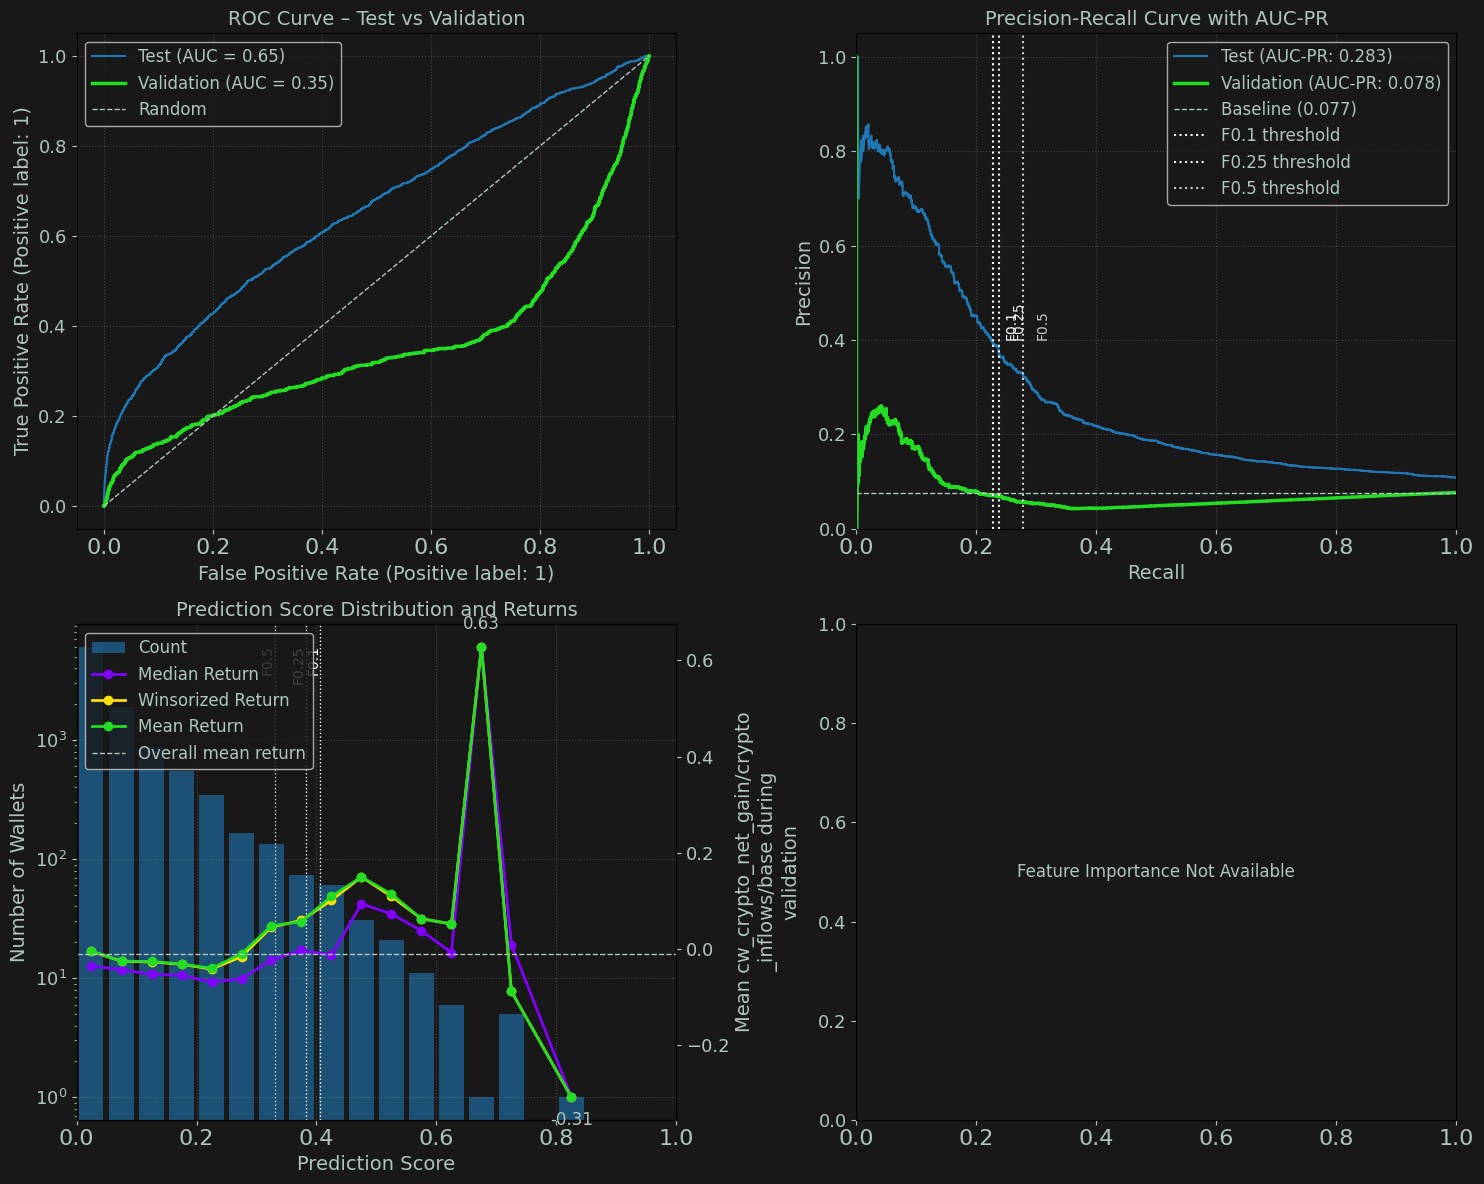

[13/Aug/25 12:45:37] INFO [690273200.<module>:4] -------------------------------------------------
[13/Aug/25 12:45:37] WARNING [690273200.<module>:5]                 -300: 2023-06-10
[13/Aug/25 12:45:37] INFO [690273200.<module>:6] -------------------------------------------------
[13/Aug/25 12:45:37] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh-300/wscr-dda-956--sh-300-0813-120606/output/model.tar.gz
Test Samples:             17,252
Val Positive Samples:     1,432 (6.4%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.592  |  0.682
Val Accuracy:               0.903  |  0.884
Val Precision:              0.062  |  0.353
Val Recall:                 0.036  |  0.109
Val F1 Score:               0.046  |  0.166

Validation

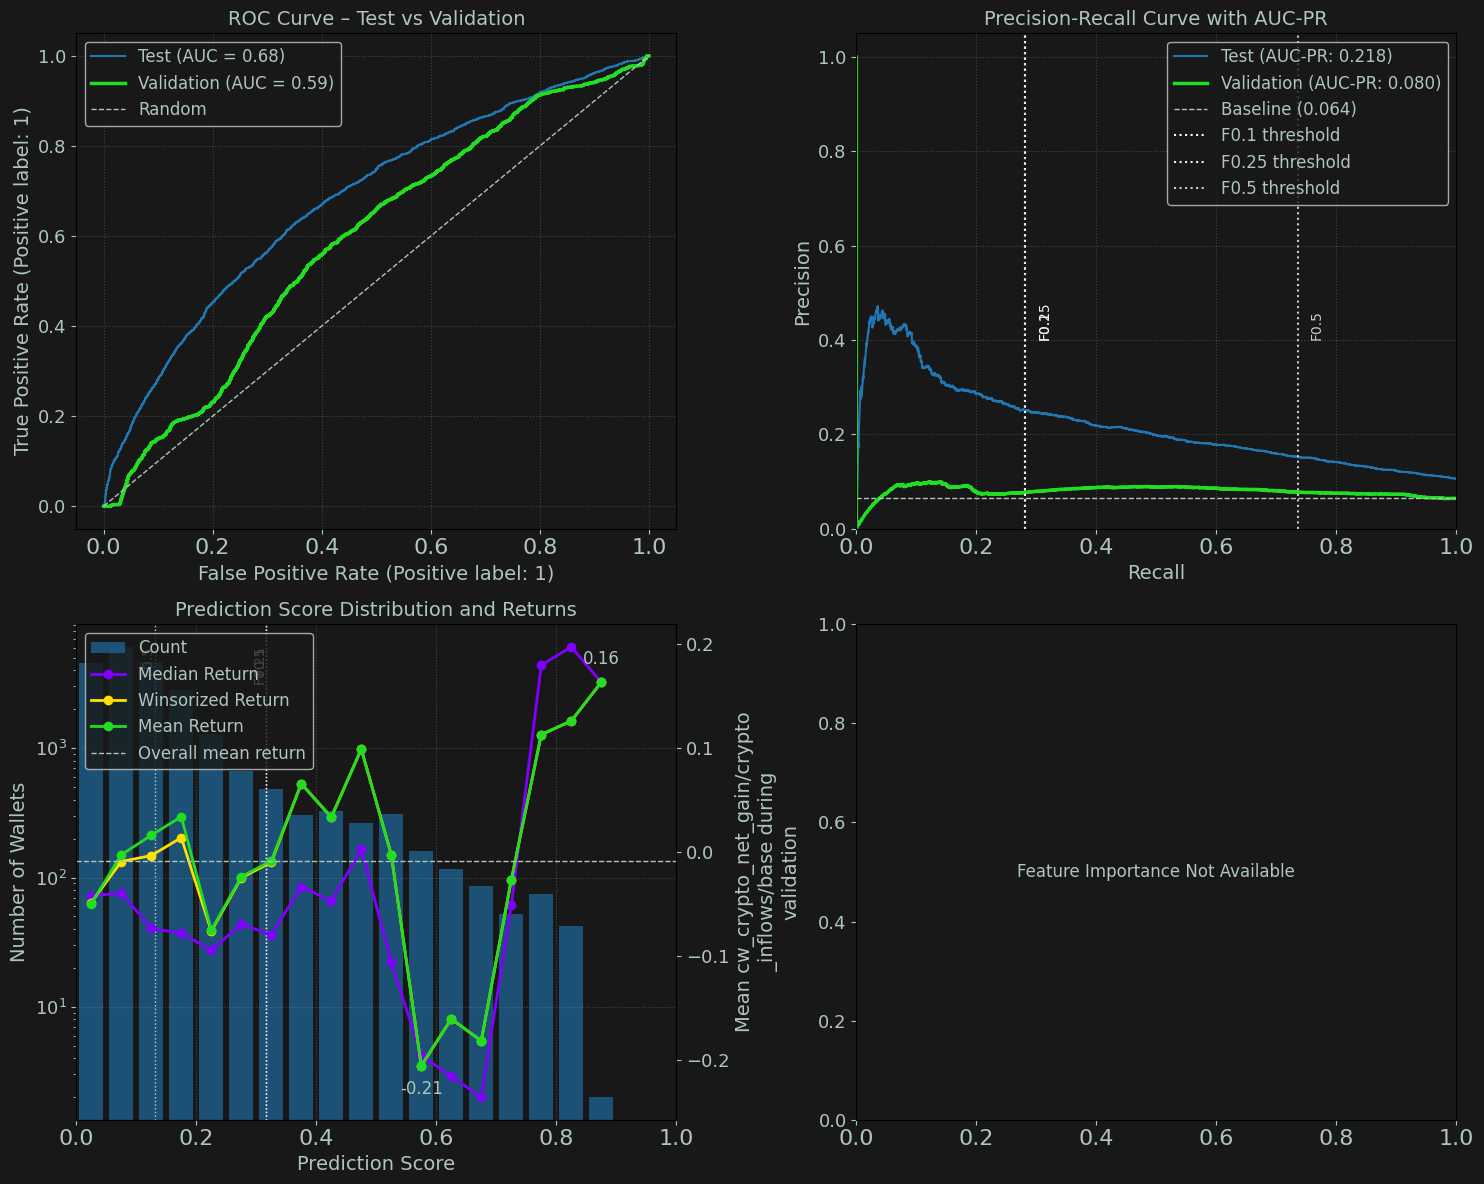

[13/Aug/25 12:45:37] INFO [690273200.<module>:4] -------------------------------------------------
[13/Aug/25 12:45:37] WARNING [690273200.<module>:5]                 -240: 2023-08-09
[13/Aug/25 12:45:37] INFO [690273200.<module>:6] -------------------------------------------------
[13/Aug/25 12:45:37] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh-240/wscr-dda-956--sh-240-0813-120606/output/model.tar.gz
Test Samples:             18,101
Val Positive Samples:     4,435 (19.9%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.538  |  0.710
Val Accuracy:               0.789  |  0.907
Val Precision:              0.237  |  0.481
Val Recall:                 0.027  |  0.182
Val F1 Score:               0.048  |  0.264

Validatio

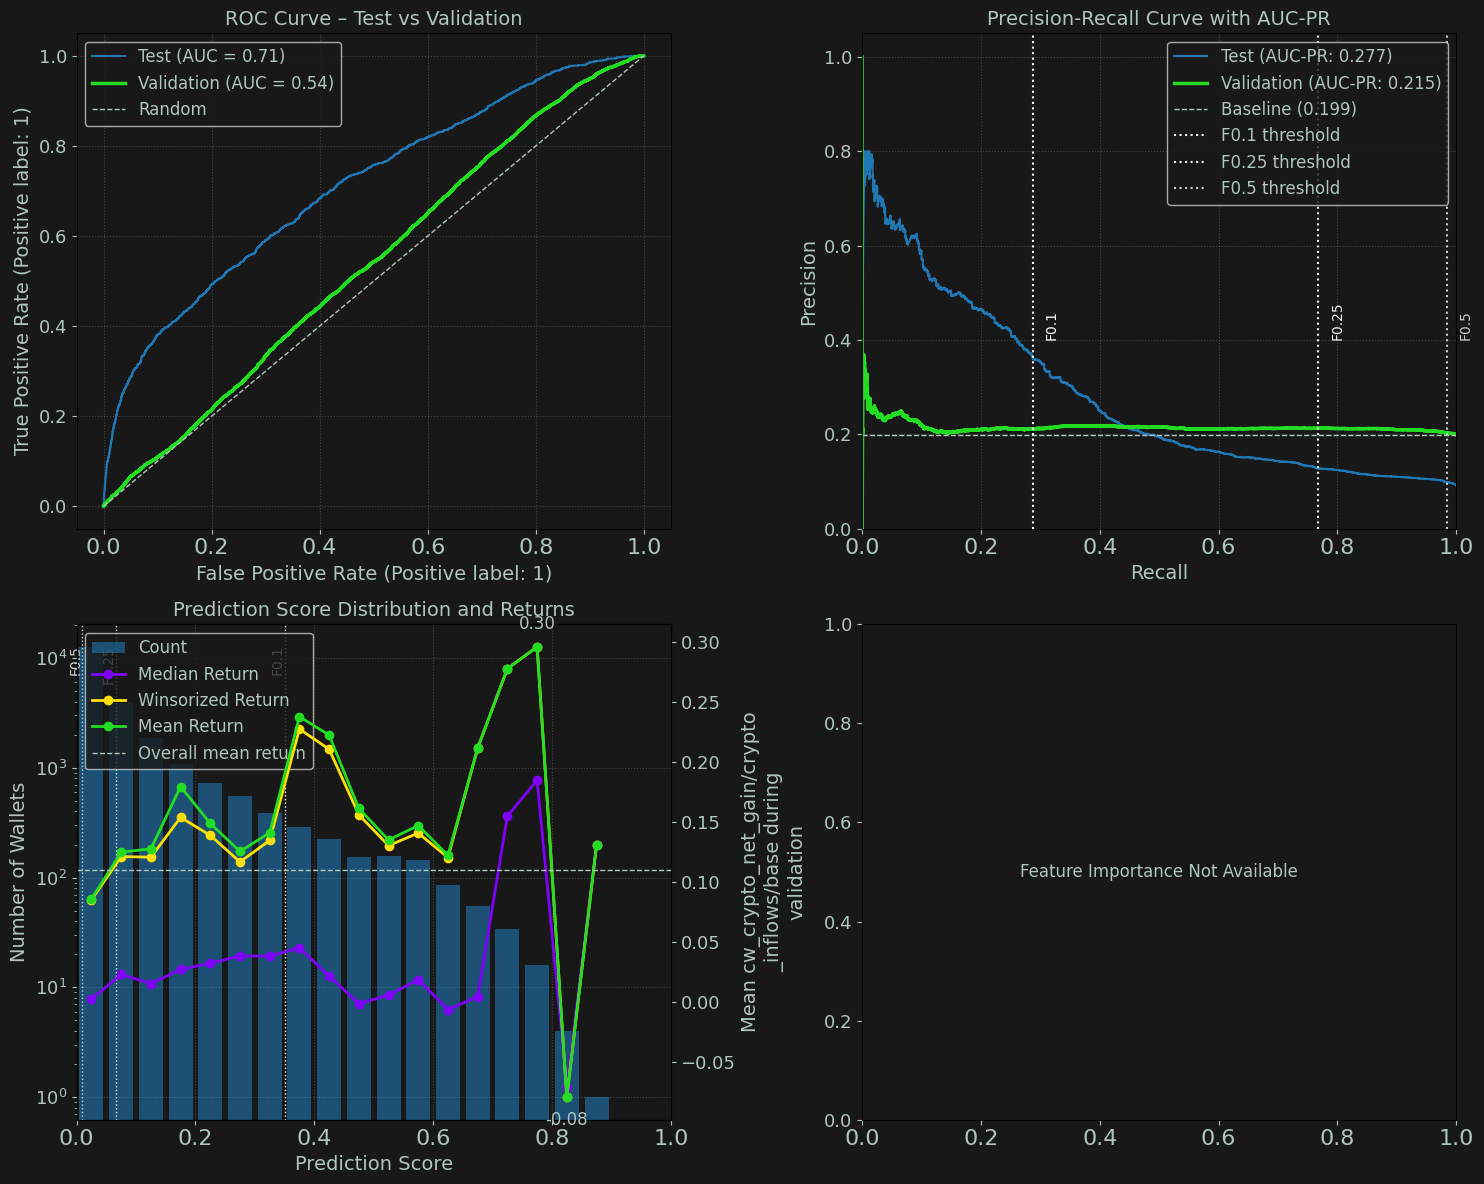

[13/Aug/25 12:45:38] INFO [690273200.<module>:4] -------------------------------------------------
[13/Aug/25 12:45:38] WARNING [690273200.<module>:5]                 -180: 2023-10-08
[13/Aug/25 12:45:38] INFO [690273200.<module>:6] -------------------------------------------------
[13/Aug/25 12:45:38] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh-180/wscr-dda-956--sh-180-0813-120606/output/model.tar.gz
Test Samples:             19,089
Val Positive Samples:     8,358 (17.0%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.541  |  0.755
Val Accuracy:               0.666  |  0.888
Val Precision:              0.182  |  0.510
Val Recall:                 0.278  |  0.352
Val F1 Score:               0.220  |  0.416

Validatio

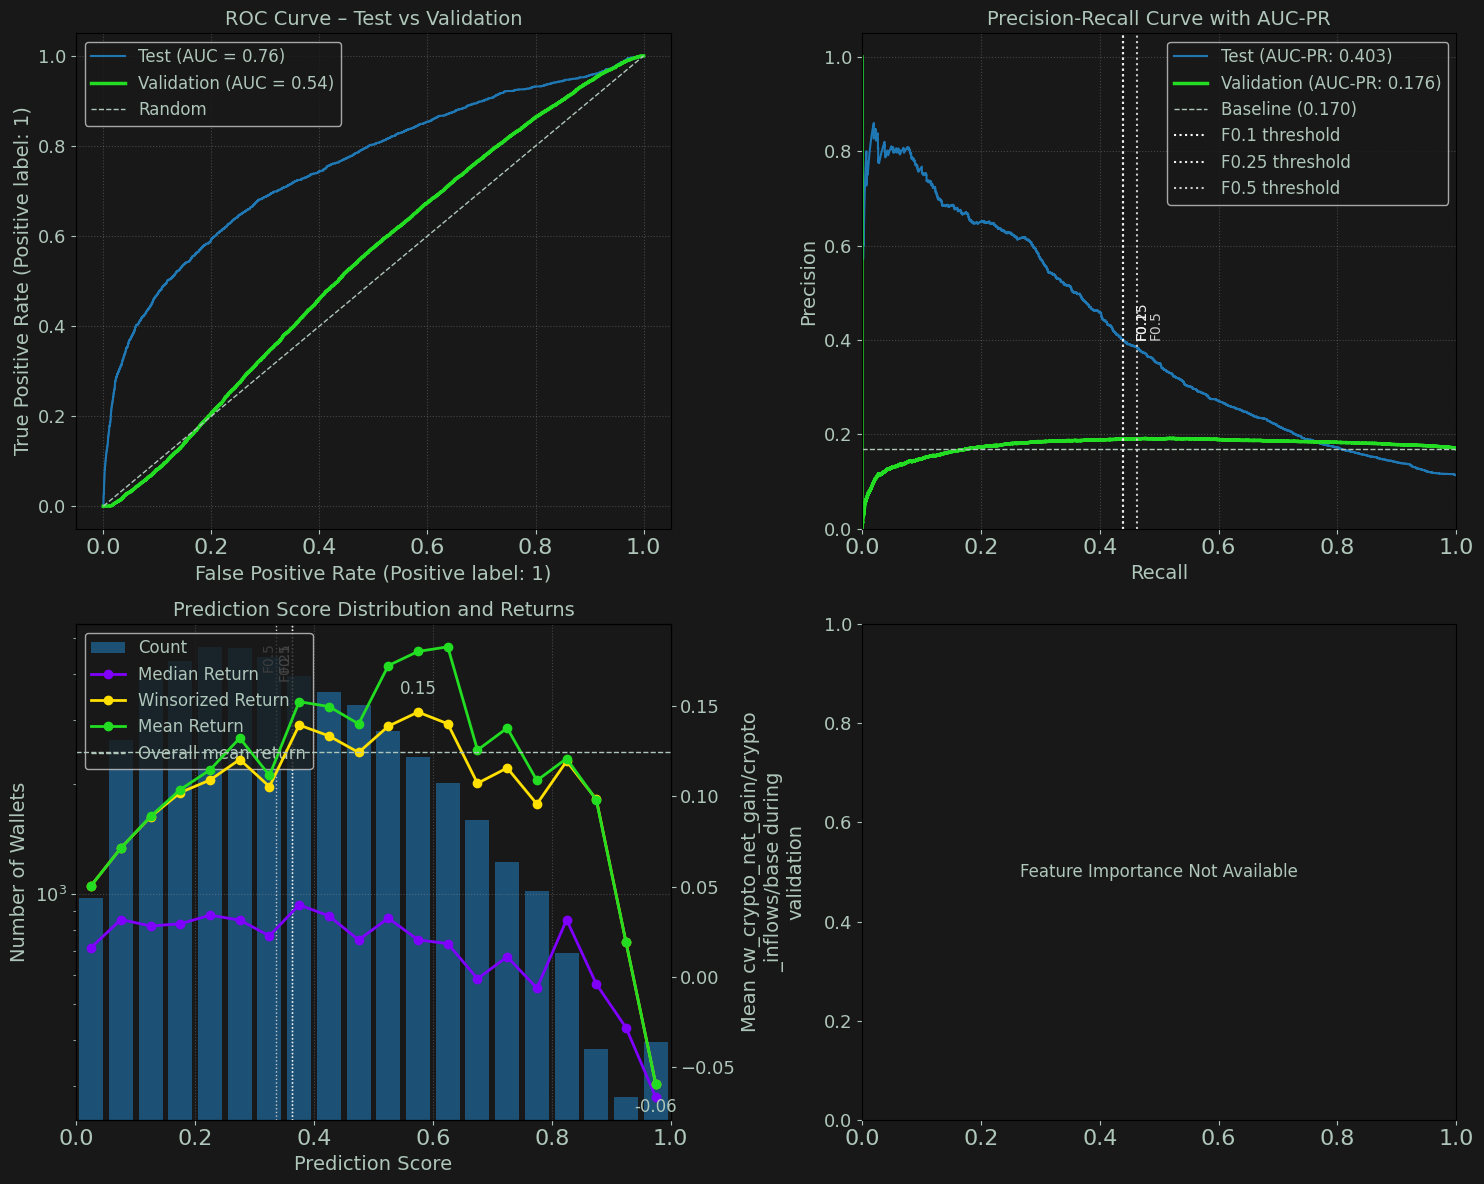

[13/Aug/25 12:45:38] INFO [690273200.<module>:4] -------------------------------------------------
[13/Aug/25 12:45:38] WARNING [690273200.<module>:5]                 -120: 2023-12-07
[13/Aug/25 12:45:38] INFO [690273200.<module>:6] -------------------------------------------------
[13/Aug/25 12:45:38] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh-120/wscr-dda-956--sh-120-0813-120606/output/model.tar.gz
Test Samples:             24,328
Val Positive Samples:     17,020 (26.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.594  |  0.760
Val Accuracy:               0.721  |  0.872
Val Precision:              0.342  |  0.544
Val Recall:                 0.059  |  0.362
Val F1 Score:               0.100  |  0.435

Validati

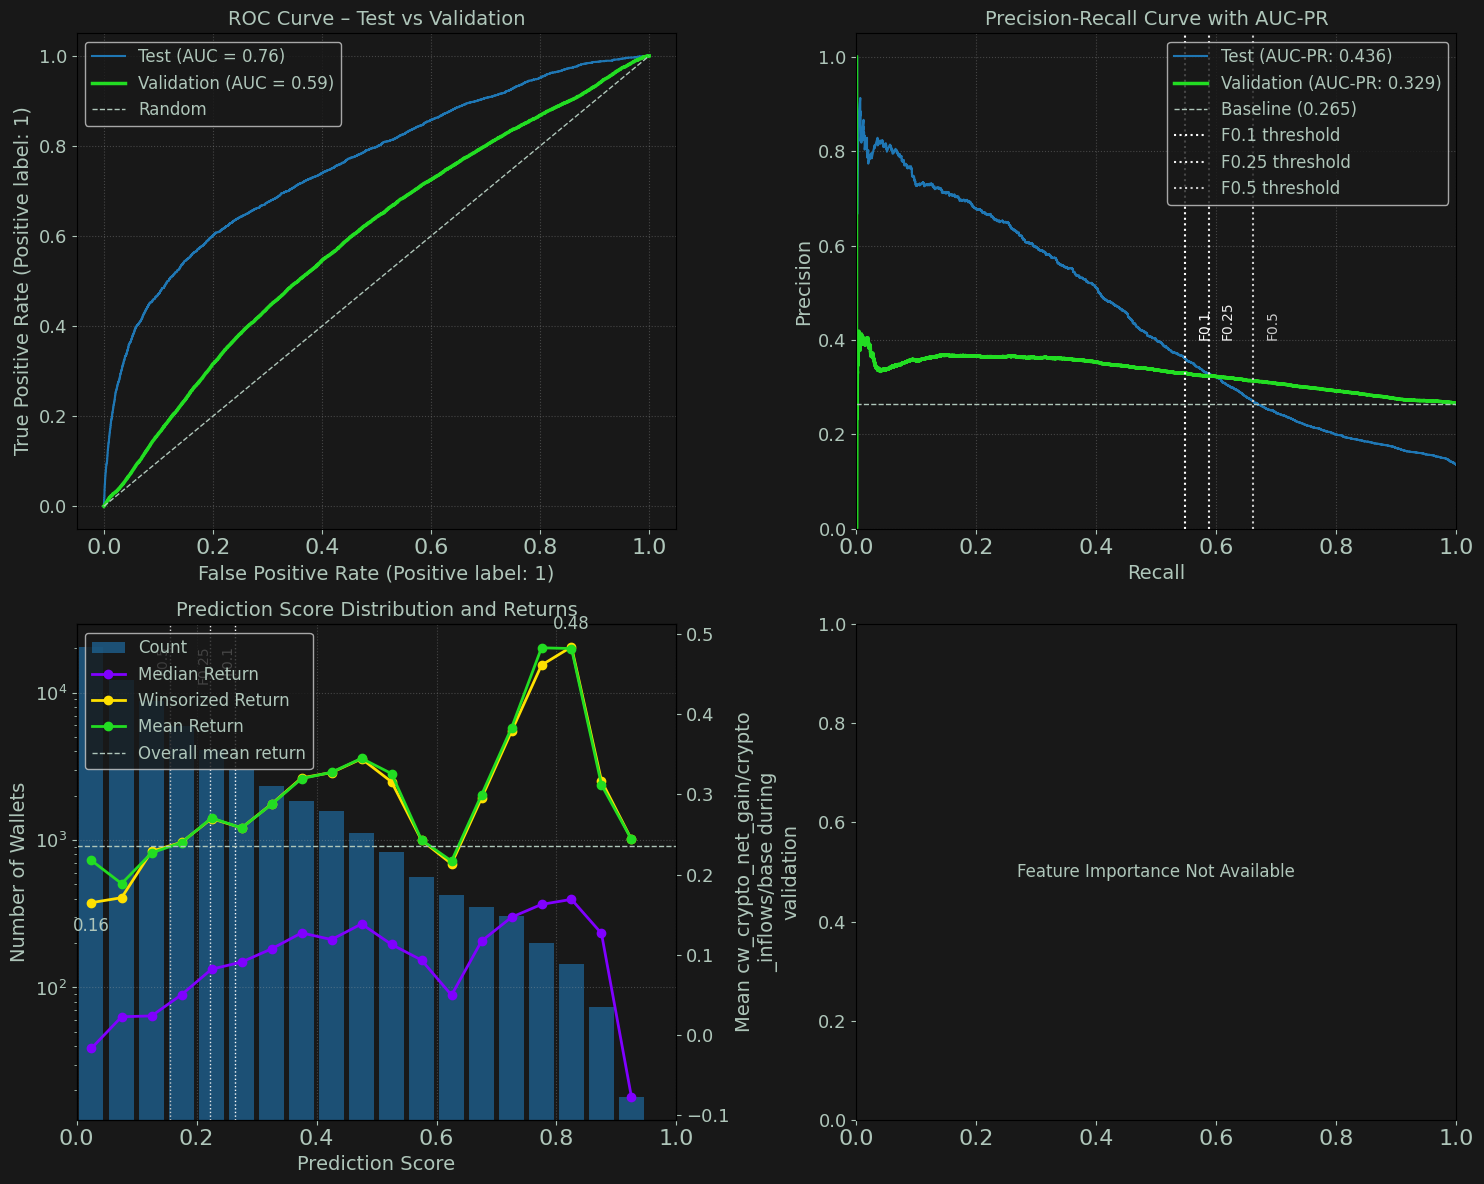

[13/Aug/25 12:45:39] INFO [690273200.<module>:4] -------------------------------------------------
[13/Aug/25 12:45:39] WARNING [690273200.<module>:5]                 -60: 2024-02-05
[13/Aug/25 12:45:39] INFO [690273200.<module>:6] -------------------------------------------------
[13/Aug/25 12:45:39] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh-60/wscr-dda-956--sh-60-0813-120606/output/model.tar.gz
Test Samples:             30,847
Val Positive Samples:     13,036 (12.0%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.594  |  0.848
Val Accuracy:               0.741  |  0.864
Val Precision:              0.169  |  0.592
Val Recall:                 0.295  |  0.661
Val F1 Score:               0.215  |  0.624

Validation 

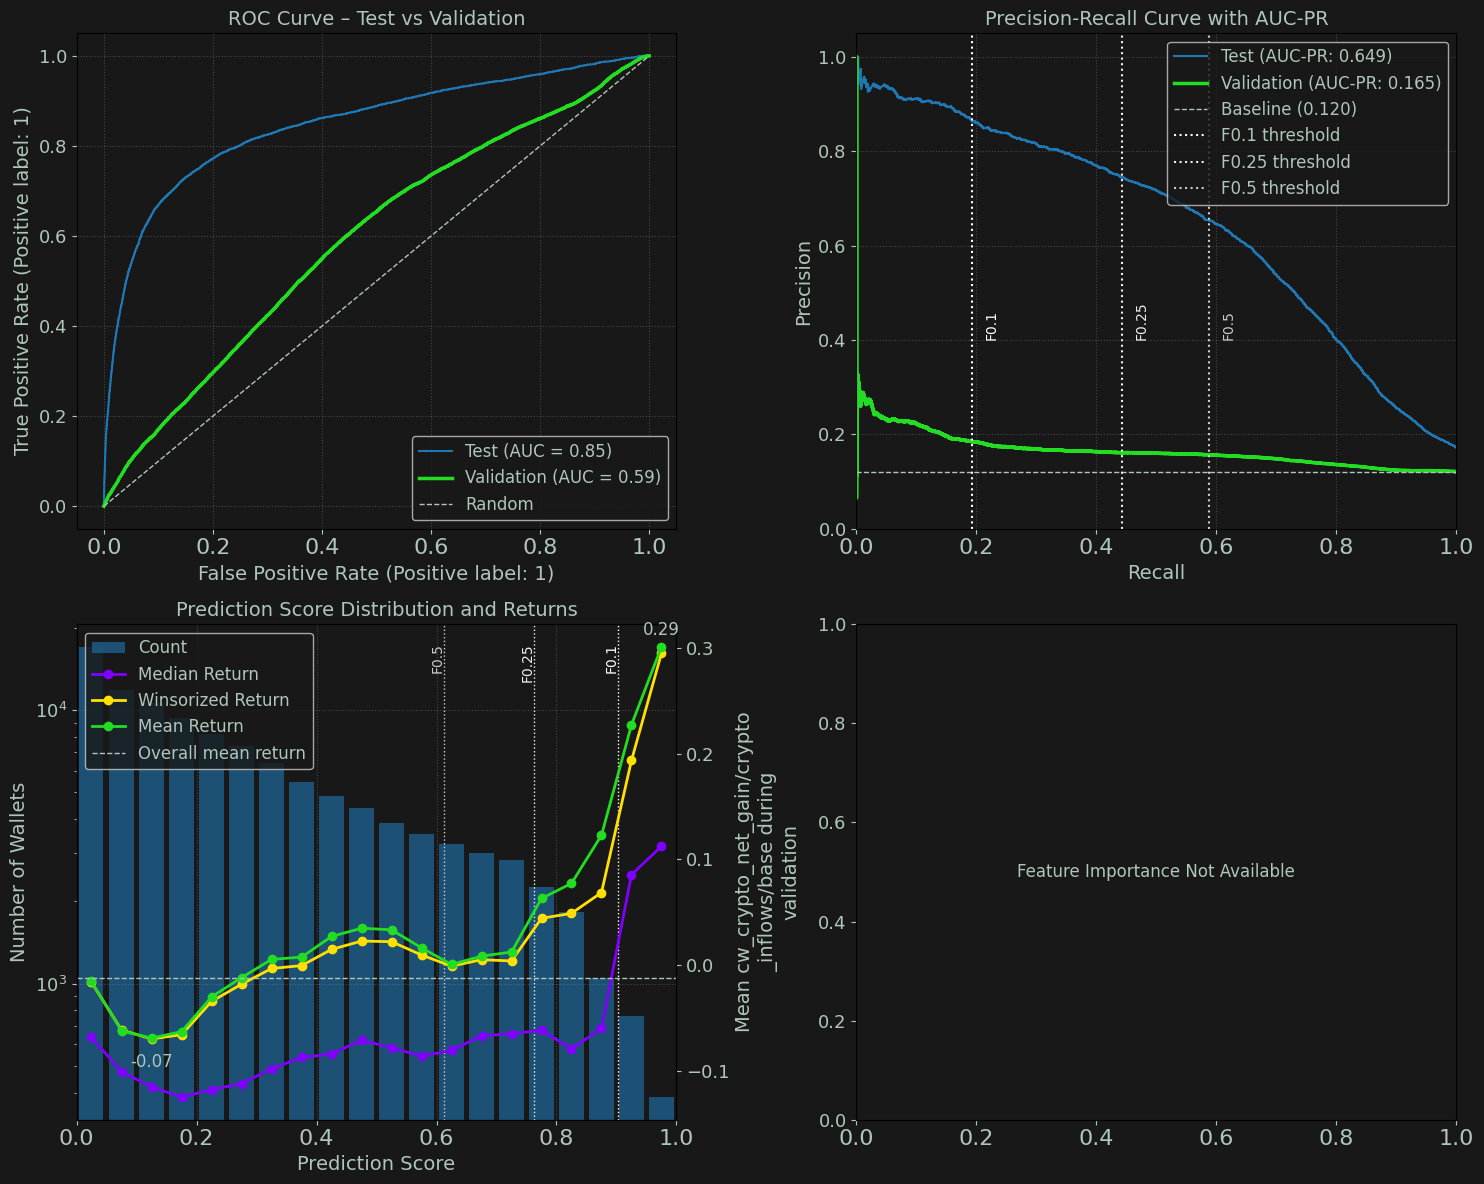

[13/Aug/25 12:45:39] INFO [690273200.<module>:4] -------------------------------------------------
[13/Aug/25 12:45:39] WARNING [690273200.<module>:5]                 0: 2024-04-05
[13/Aug/25 12:45:39] INFO [690273200.<module>:6] -------------------------------------------------
[13/Aug/25 12:45:39] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh0/wscr-dda-956--sh0-0813-120639/output/model.tar.gz
Test Samples:             43,560
Val Positive Samples:     4,293 (4.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.591  |  0.807
Val Accuracy:               0.948  |  0.854
Val Precision:              0.197  |  0.536
Val Recall:                 0.050  |  0.562
Val F1 Score:               0.079  |  0.549

Validation Returns 

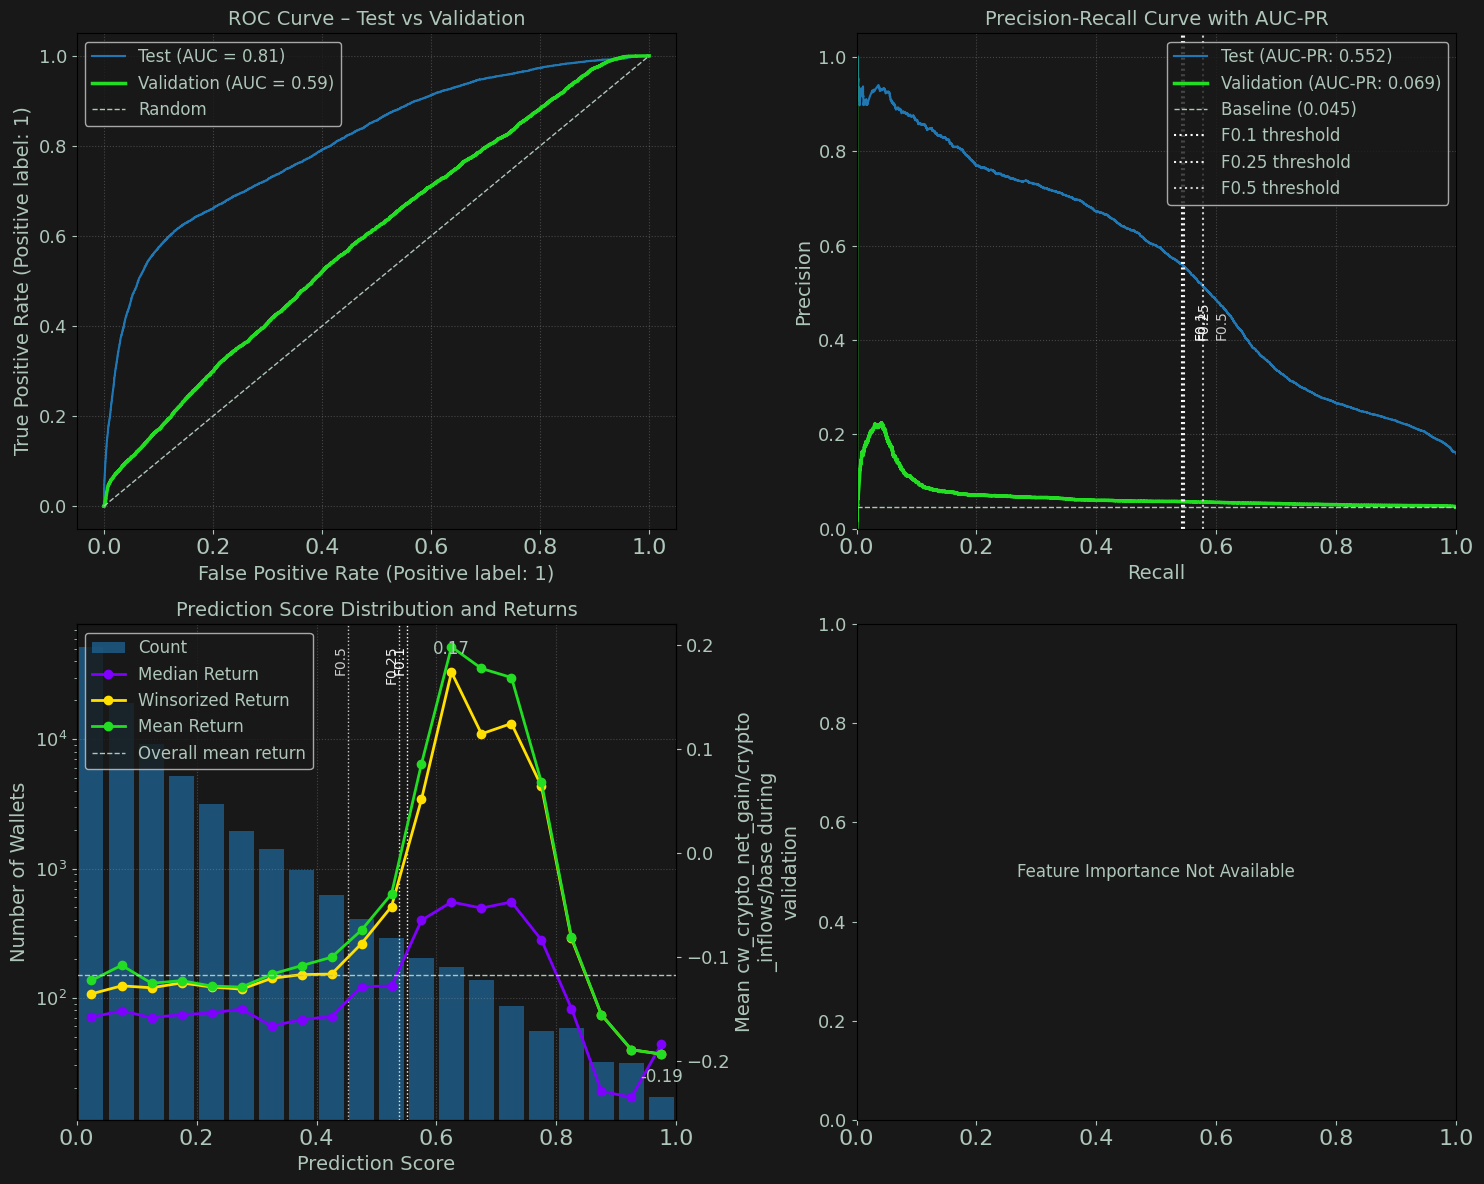

[13/Aug/25 12:45:39] INFO [690273200.<module>:4] -------------------------------------------------
[13/Aug/25 12:45:39] WARNING [690273200.<module>:5]                 60: 2024-06-04
[13/Aug/25 12:45:39] INFO [690273200.<module>:6] -------------------------------------------------
[13/Aug/25 12:45:39] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh60/wscr-dda-956--sh60-0813-120606/output/model.tar.gz
Test Samples:             54,222
Val Positive Samples:     4,166 (5.2%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.606  |  0.794
Val Accuracy:               0.942  |  0.884
Val Precision:              0.010  |  0.586
Val Recall:                 0.001  |  0.468
Val F1 Score:               0.002  |  0.520

Validation Retur

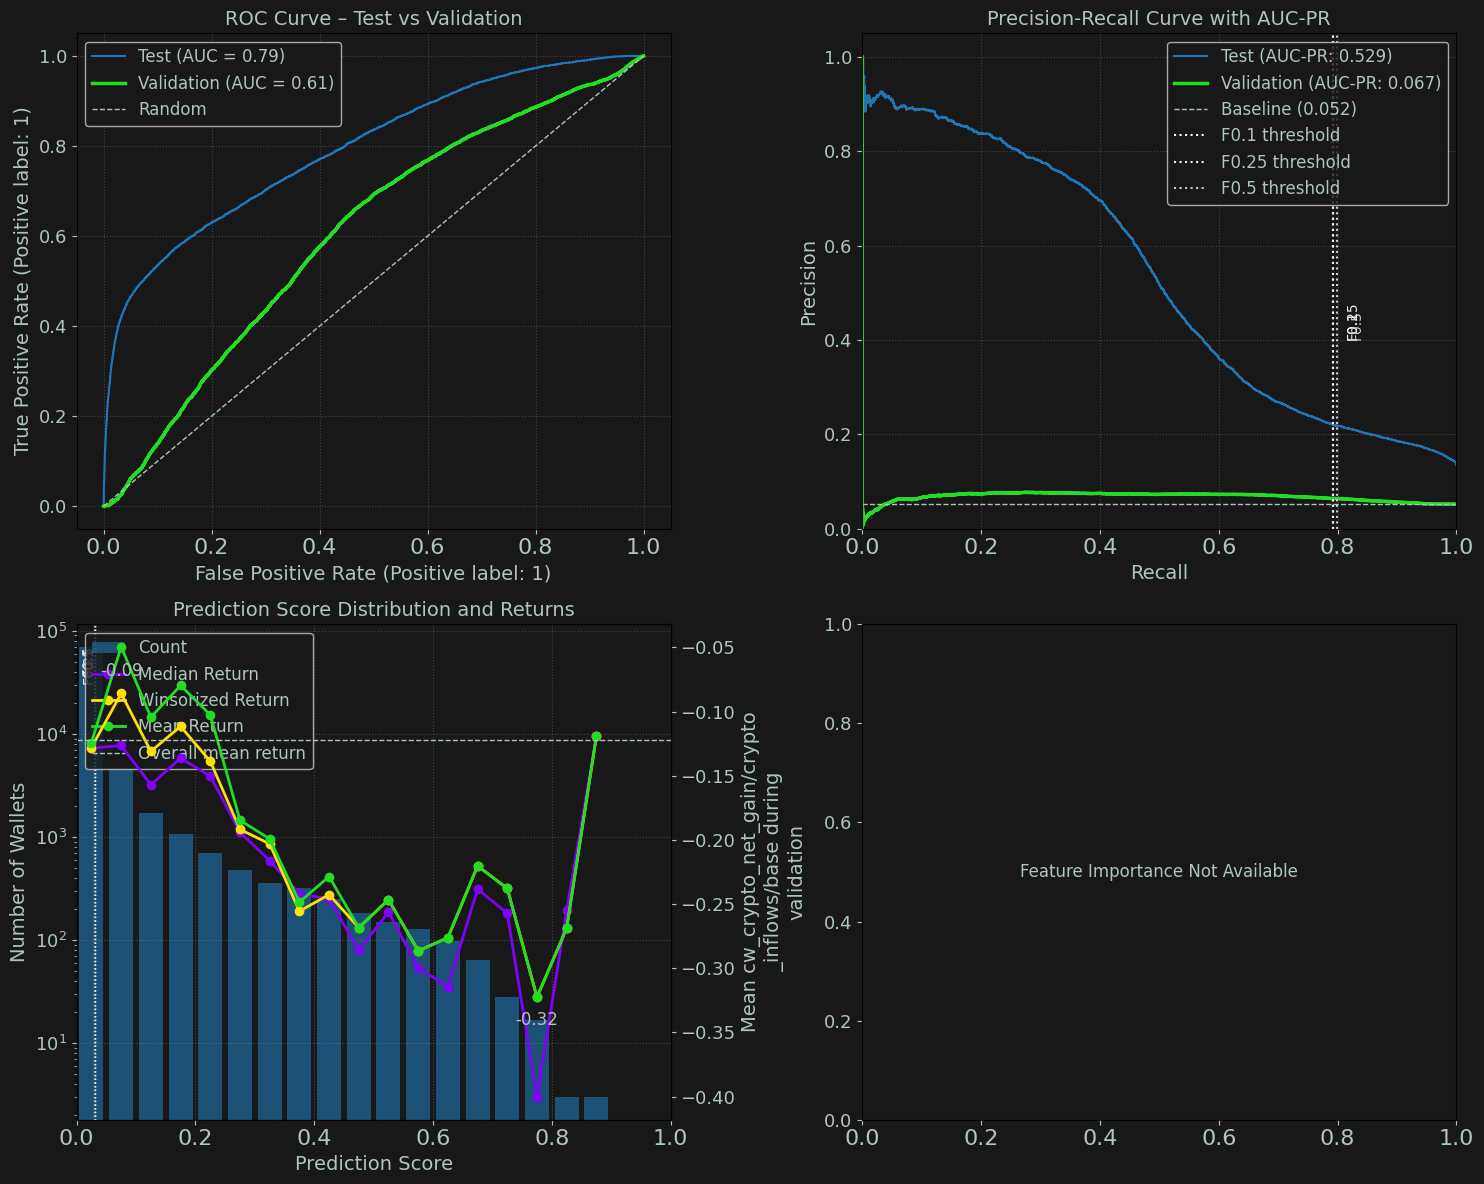

[13/Aug/25 12:45:40] INFO [690273200.<module>:4] -------------------------------------------------
[13/Aug/25 12:45:40] WARNING [690273200.<module>:5]                 120: 2024-08-03
[13/Aug/25 12:45:40] INFO [690273200.<module>:6] -------------------------------------------------
[13/Aug/25 12:45:40] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh120/wscr-dda-956--sh120-0813-120606/output/model.tar.gz
Test Samples:             62,823
Val Positive Samples:     16,969 (21.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.502  |  0.778
Val Accuracy:               0.776  |  0.887
Val Precision:              0.179  |  0.549
Val Recall:                 0.011  |  0.457
Val F1 Score:               0.022  |  0.499

Validation 

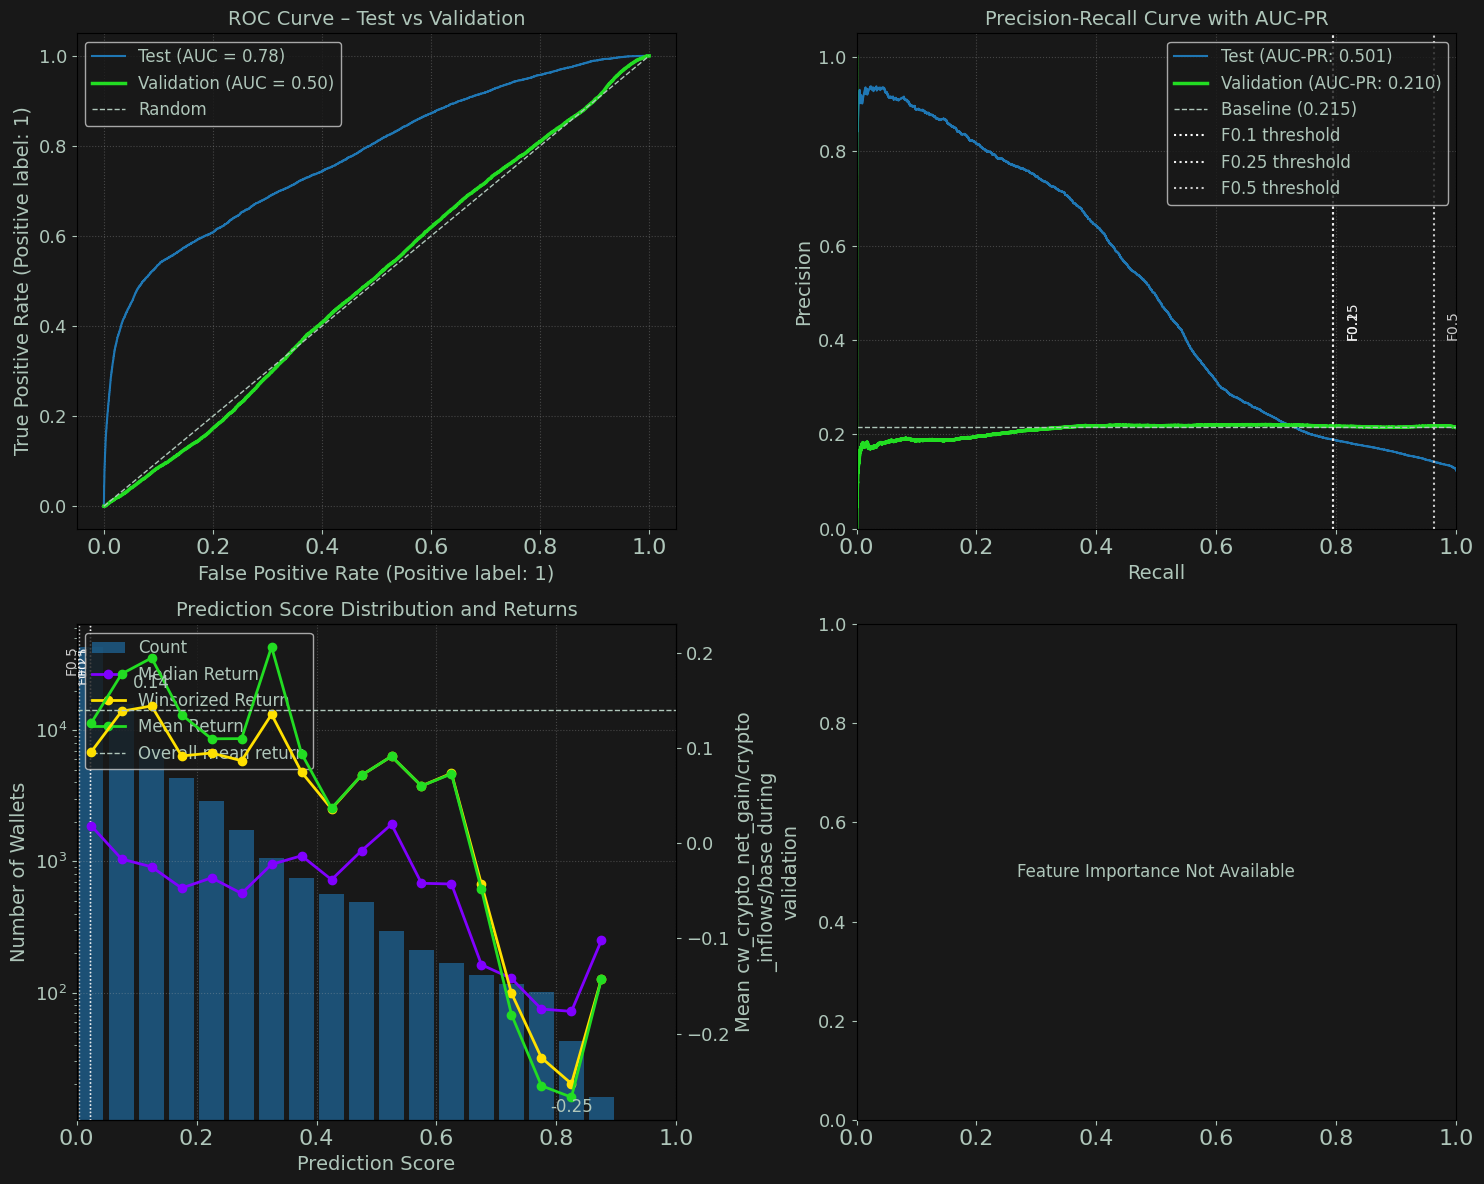

[13/Aug/25 12:45:40] INFO [690273200.<module>:4] -------------------------------------------------
[13/Aug/25 12:45:40] WARNING [690273200.<module>:5]                 180: 2024-10-02
[13/Aug/25 12:45:40] INFO [690273200.<module>:6] -------------------------------------------------
[13/Aug/25 12:45:40] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh180/wscr-dda-956--sh180-0813-120606/output/model.tar.gz
Test Samples:             71,283
Val Positive Samples:     30,224 (24.9%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.454  |  0.780
Val Accuracy:               0.741  |  0.887
Val Precision:              0.225  |  0.639
Val Recall:                 0.016  |  0.378
Val F1 Score:               0.030  |  0.475

Validation 

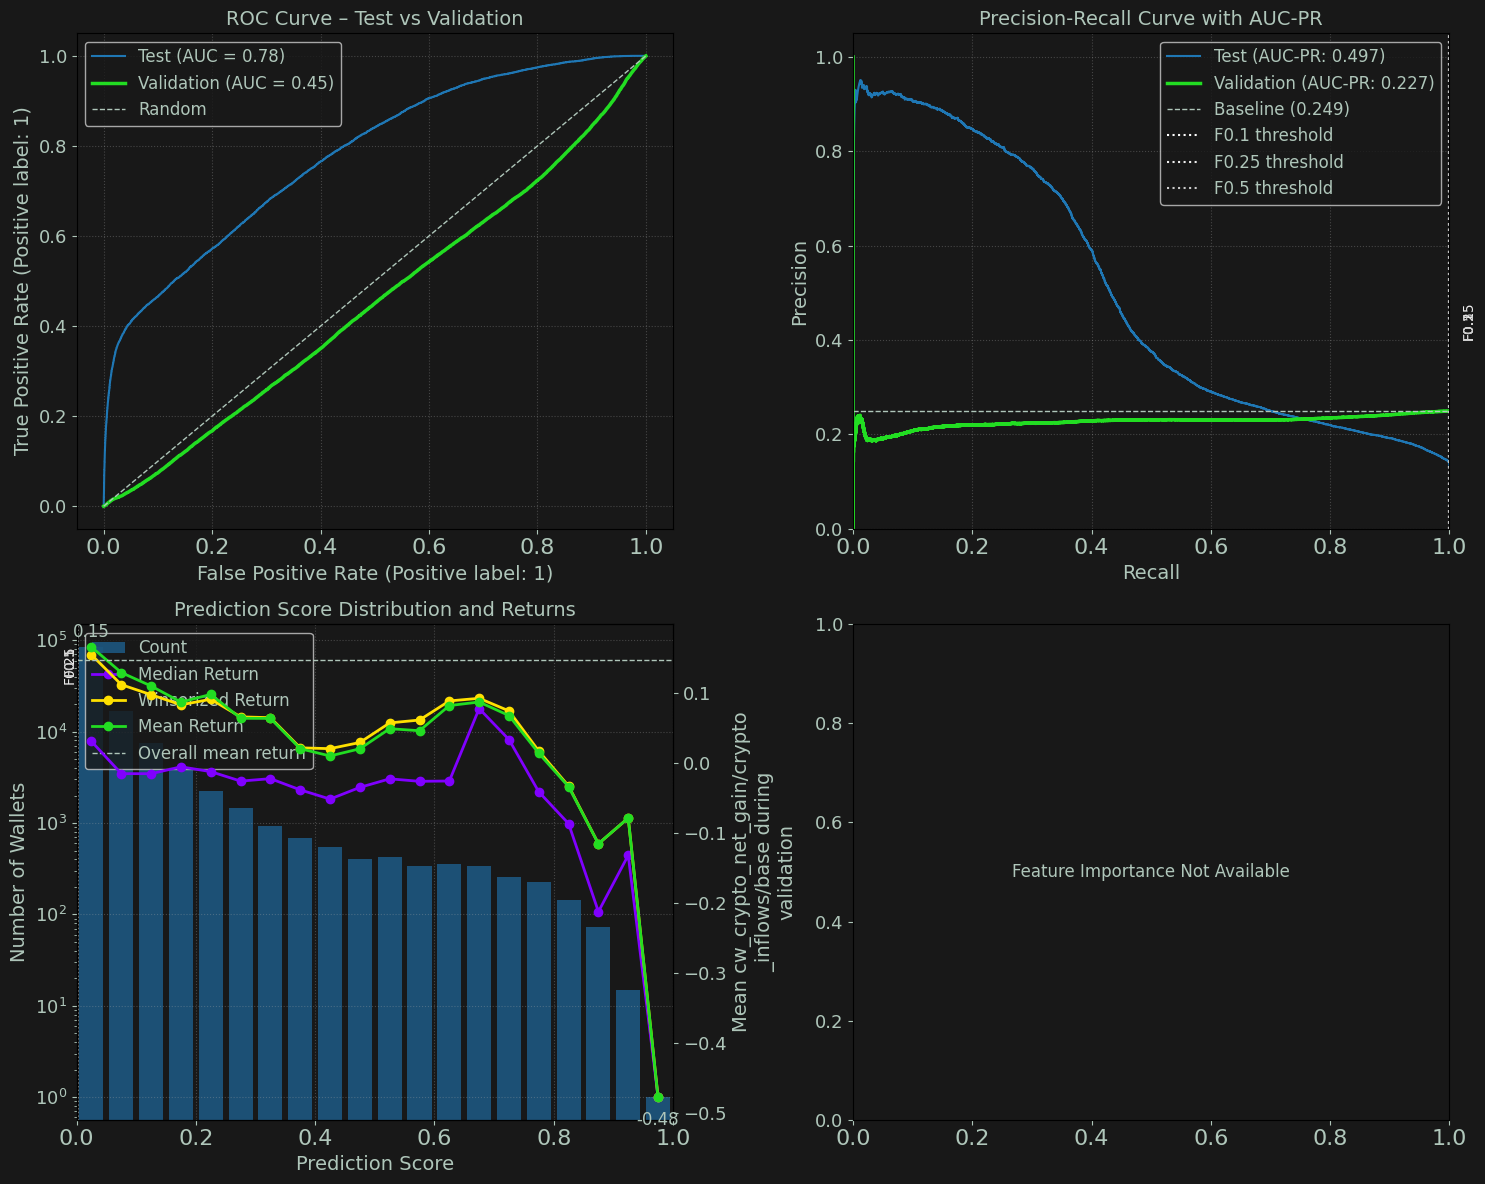

[13/Aug/25 12:45:40] INFO [690273200.<module>:4] -------------------------------------------------
[13/Aug/25 12:45:40] WARNING [690273200.<module>:5]                 240: 2024-12-01
[13/Aug/25 12:45:40] INFO [690273200.<module>:6] -------------------------------------------------
[13/Aug/25 12:45:40] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh240/wscr-dda-956--sh240-0813-120606/output/model.tar.gz
Test Samples:             82,276
Val Positive Samples:     5,235 (4.9%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.555  |  0.698
Val Accuracy:               0.867  |  0.859
Val Precision:              0.076  |  0.605
Val Recall:                 0.155  |  0.307
Val F1 Score:               0.102  |  0.407

Validation Re

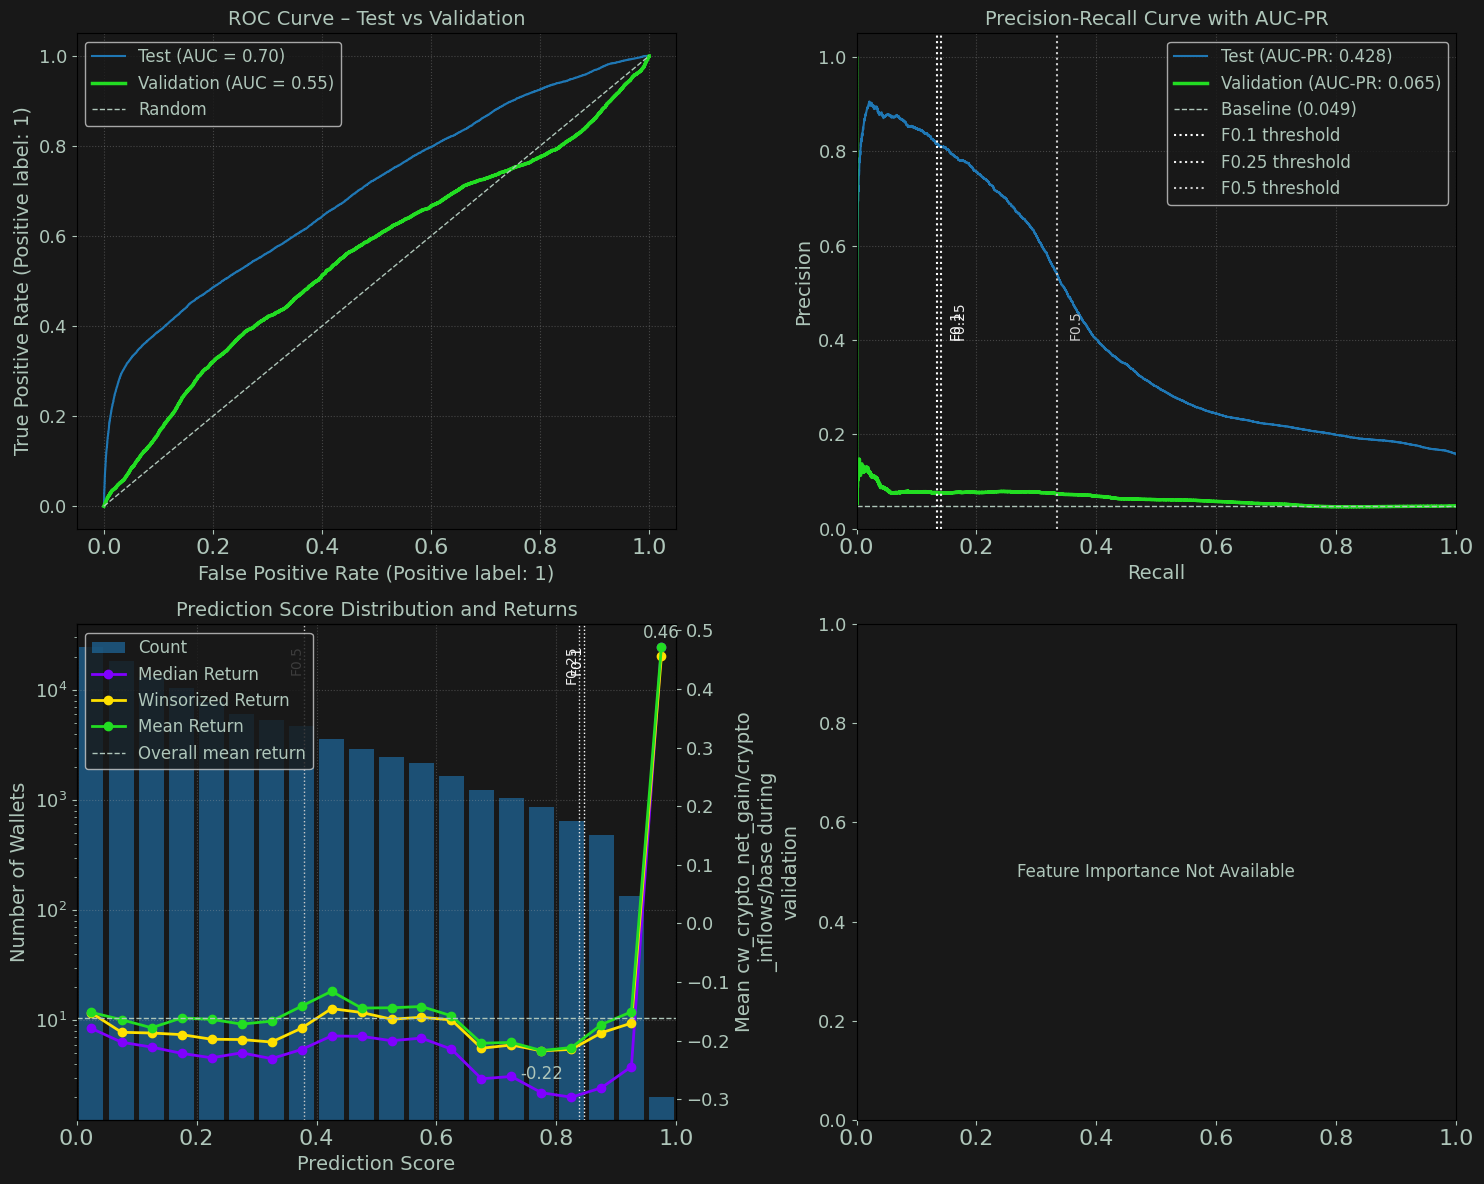

[13/Aug/25 12:45:41] INFO [690273200.<module>:4] -------------------------------------------------
[13/Aug/25 12:45:41] WARNING [690273200.<module>:5]                 300: 2025-01-30
[13/Aug/25 12:45:41] INFO [690273200.<module>:6] -------------------------------------------------
[13/Aug/25 12:45:41] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh300/wscr-dda-956--sh300-0813-120606/output/model.tar.gz
Test Samples:             88,816
Val Positive Samples:     3,856 (8.0%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.707  |  0.684
Val Accuracy:               0.902  |  0.879
Val Precision:              0.289  |  0.561
Val Recall:                 0.149  |  0.172
Val F1 Score:               0.196  |  0.263

Validation Re

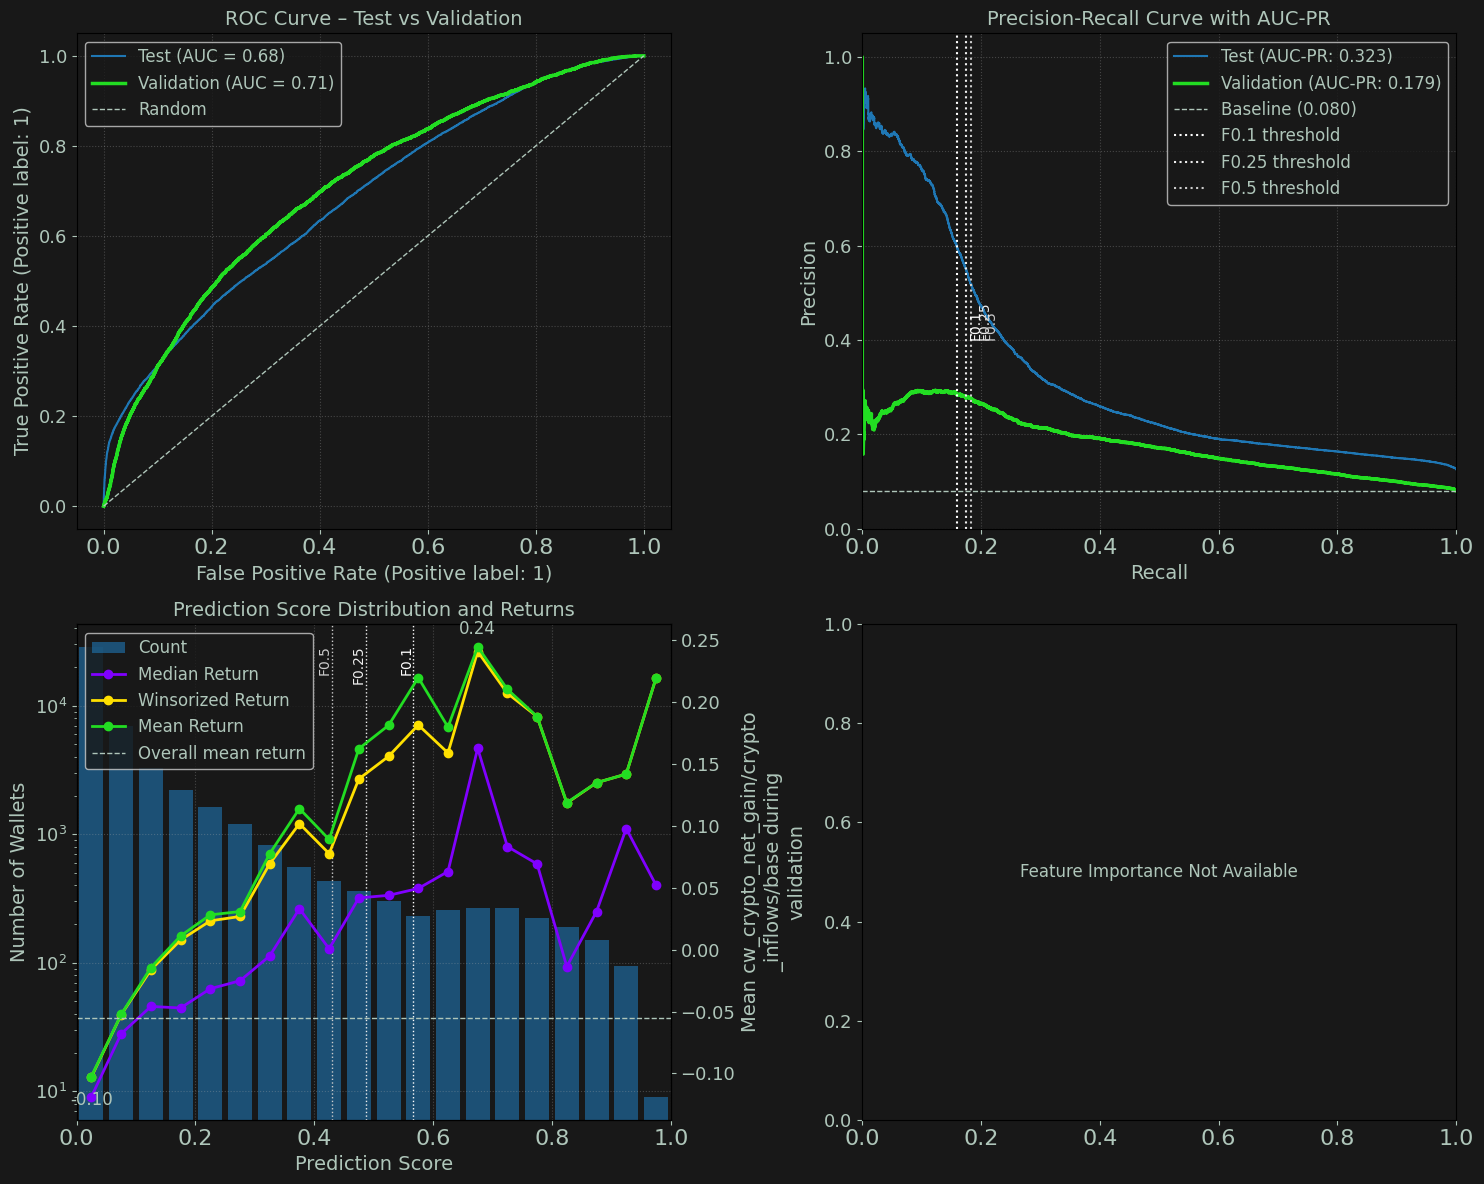

[13/Aug/25 12:45:41] INFO [690273200.<module>:4] -------------------------------------------------
[13/Aug/25 12:45:41] WARNING [690273200.<module>:5]                 360: 2025-03-31
[13/Aug/25 12:45:41] INFO [690273200.<module>:6] -------------------------------------------------
[13/Aug/25 12:45:41] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh360/wscr-dda-956--sh360-0813-120606/output/model.tar.gz
Test Samples:             79,769
Val Positive Samples:     5,706 (12.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.586  |  0.667
Val Accuracy:               0.855  |  0.887
Val Precision:              0.137  |  0.617
Val Recall:                 0.029  |  0.220
Val F1 Score:               0.048  |  0.324

Validation R

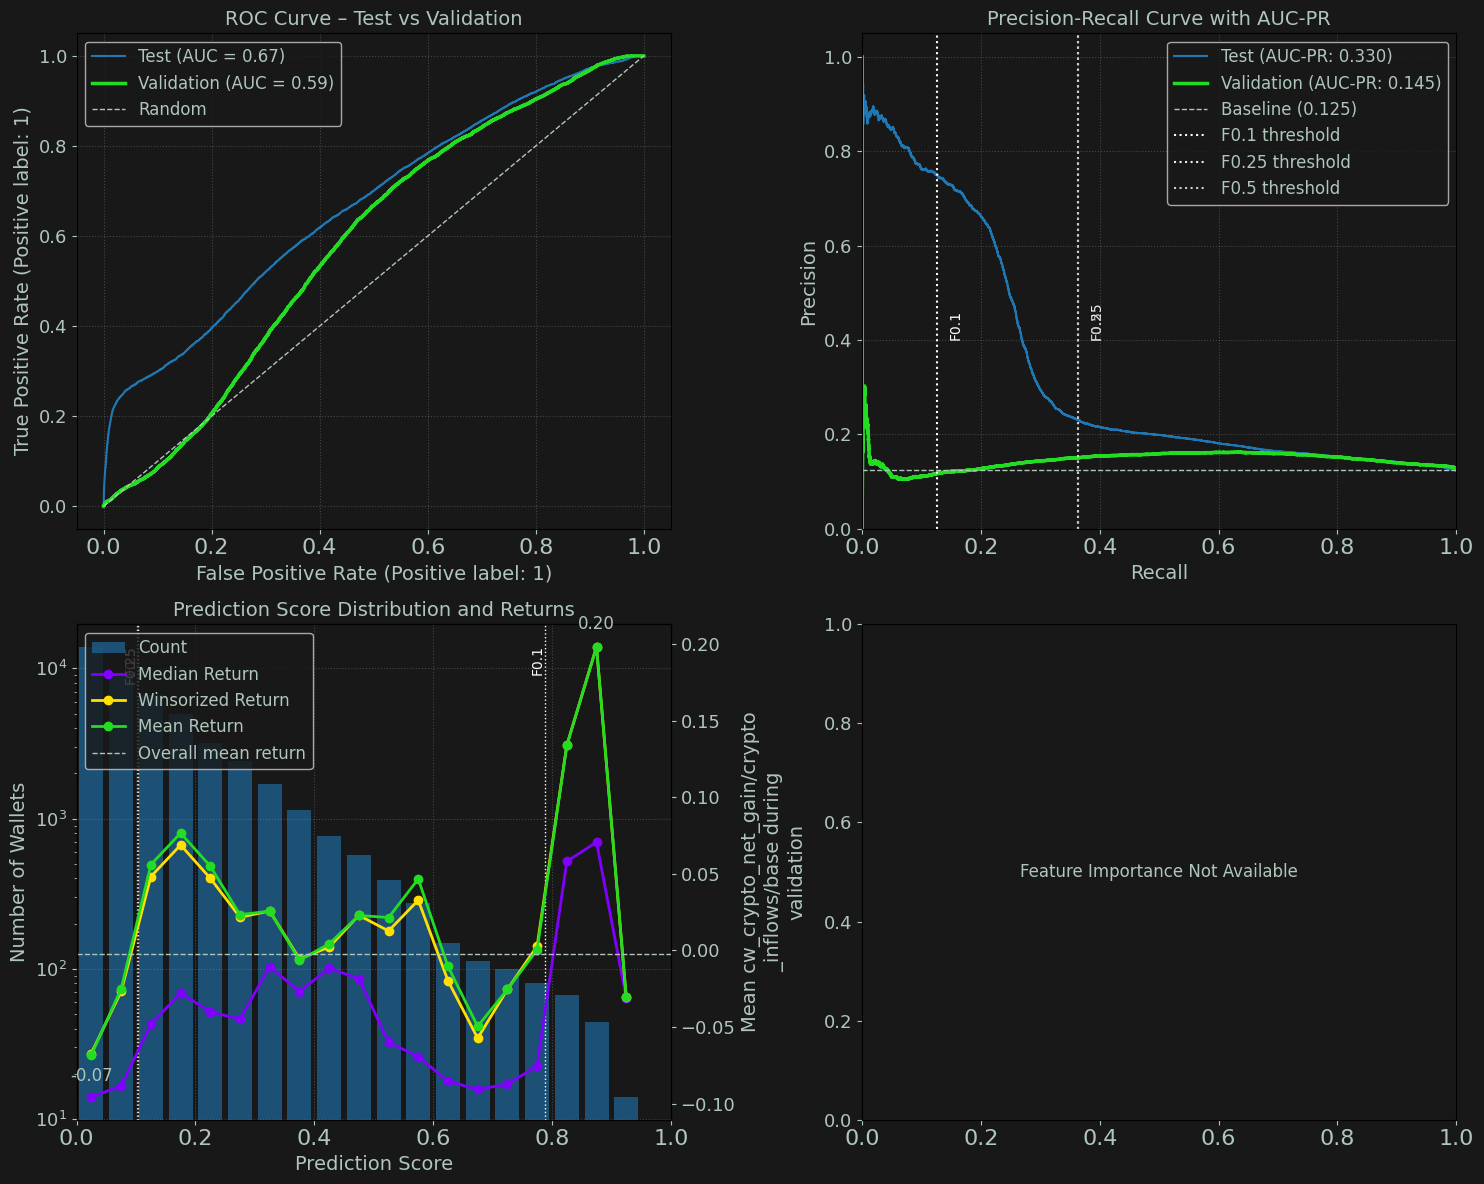

In [40]:
for e in evaluators:
    # evaluators[e].summary_report()
    date = (pd.to_datetime('2024-04-05') + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info('-------------------------------------------------')
    logger.warning(f'                {e}: {date}')
    logger.info('-------------------------------------------------')
    if evaluators[e] is None:
        logger.warning("All rows filtered out")
        continue
    evaluators[e].summary_report()
    evaluators[e].plot_wallet_evaluation()


#### predict and filter data by epoch_shift

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

epoch_shift = sage_wallets_config['training_data']['epoch_shifts'][0]

# Create modeler with epoch_shift as the date_suffix
shift_s3_uris = {f'sh{epoch_shift}': s3_uris['concat']}
concat_modeler = wm.WalletModeler(
    wallets_config=sage_wallets_config,
    modeling_config=sage_wallets_modeling_config,
    date_suffix=f'sh{epoch_shift}',
    s3_uris=shift_s3_uris,
    override_approvals=None
)

# Load the existing concatenated model
model_info = concat_modeler.load_existing_model(epoch_shift=epoch_shift)

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

epoch_shift = sage_wallets_config['training_data']['epoch_shifts'][0]

date_suffix = f'sh{epoch_shift}'
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_test      = sime.load_concatenated_y('test', sage_wallets_config, sage_wallets_modeling_config)
y_val_pred  = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)
y_val       = sime.load_concatenated_y('val', sage_wallets_config, sage_wallets_modeling_config)


target_var = sage_wallets_modeling_config['target']['target_var']
y_test.columns = [target_var]
y_val.columns = [target_var]

# Single function call for complete evaluation
evaluator = sime.create_concatenated_sagemaker_evaluator(
    sage_wallets_config,
    sage_wallets_modeling_config,
    model_info['model_uri'],
    y_test_pred,
    y_test,
    y_val_pred,
    y_val,
    epoch_shift
)

In [ ]:
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


### Single Model Sequence

#### train

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
concat_uris = workflow_orch.upload_concatenated_training_data(overwrite_existing=False)
modeling_results = workflow_orch.train_concatenated_offsets_model(concat_uris)

#### evaluate HPO outcomes

In [ ]:
player = u.AmbientPlayer()
player.stop_all_players()

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
workflow_orch.get_hpo_results('concat')

In [ ]:
# Get the best hyperparameters
best_params = modeling_results['tuner'].best_training_job()

# Or more detailed info
analytics = modeling_results['tuner'].analytics()
best_job_df = analytics.dataframe()

# The best parameters are in the hyperparameters columns
print(best_params)
print(best_job_df.loc[0, ['eta', 'max_depth', 'subsample', 'FinalObjectiveValue']])

#### load existing model

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

# Create modeler with 'concat' as the date_suffix
concat_modeler = wm.WalletModeler(
    wallets_config=sage_wallets_config,
    modeling_config=sage_wallets_modeling_config,
    date_suffix='concat',
    s3_uris=s3_uris,
    override_approvals=None
)

# Step 2: Load the existing concatenated model
model_info = concat_modeler.load_existing_model(modeling_results['model_uri'])


In [ ]:
model_info

#### predict

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

pred_results = concat_modeler.batch_predict_test_and_val()

#### evaluate

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

date_suffix = 'concat'
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_test      = sime.load_concatenated_y('test', sage_wallets_config, sage_wallets_modeling_config)
y_val_pred  = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)
y_val       = sime.load_concatenated_y('val', sage_wallets_config, sage_wallets_modeling_config)


target_var = sage_wallets_modeling_config['target']['target_var']
y_test.columns = [target_var]
y_val.columns = [target_var]

# Single function call for complete evaluation
evaluator = sime.create_concatenated_sagemaker_evaluator(
    sage_wallets_config,
    sage_wallets_modeling_config,
    model_info['model_uri'],
    y_test_pred,
    y_test,
    y_val_pred,
    y_val,
)

In [ ]:
# auc pr 0.4 all history
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr 0.4 all history
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr 0.4 mktcap 20M-4B
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, z score 1.5
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, inflows $5k
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, z score 1.5
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


## Temporal cv model

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


date_suffixes = [
    '231008',
    '231107',
    '240306',
    '241101',
    '250301'
]
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
workflow_orch.load_all_training_data(date_suffixes)
s3_uris = workflow_orch.retrieve_training_data_uris(date_suffixes)

In [ ]:
sm.train_temporal_cv_script_model(sage_wallets_config,sage_wallets_modeling_config,cv_s3_uri)

### Predict Using Endpoints

#### deploy endpoint for predictions

In [ ]:
modeler.list_active_endpoints()

In [ ]:
modeler.deploy_endpoint()

#### load and preprocess test/val dfs

In [ ]:
x_test = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_test_{date_suffix}.parquet"
)
x_val = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_val_{date_suffix}.parquet"
)




In [ ]:
preprocessor = SageWalletsPreprocessor(sage_wallets_config)
x_test_processed = preprocessor.preprocess_x_df(x_test)
x_val_processed = preprocessor.preprocess_x_df(x_val)

logger.info(f"Preprocessed X_test {x_test_processed.shape} and "
            f"X_val {x_val_processed.shape}.")

#### predict

In [ ]:
y_test_pred = modeler.predict_using_endpoint(x_test_processed, 'test')
y_val_pred = modeler.predict_using_endpoint(x_val_processed, 'val')

#### delete all endpoints

In [ ]:
modeler.delete_all_endpoints()

In [ ]:
modeler.list_active_endpoints()
modeler.list_all_endpoints()

# Model Evaluation

### Analyze predictions

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


date_suffixes = [
    '231008',
    # '240306'
]
date_suffix = date_suffixes[0]

In [ ]:
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_val_pred = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)

In [ ]:
# Single function call for complete evaluation
evaluator = sime.run_sagemaker_evaluation(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    y_test_pred,
    y_val_pred
)

In [ ]:
evaluator.y_validation

In [ ]:
evaluator.y_validation_pred_proba

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(evaluator.y_validation, evaluator.y_validation_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
evaluator.summary_report()
evaluator.plot_wallet_evaluation()


In [ ]:
def load_sagemaker_predictions(
    data_type: str,
    sage_wallets_config: dict,
    sage_wallets_modeling_config: dict,
    date_suffix: str
) -> tuple[pd.Series, pd.Series]:
    """
    Load SageMaker predictions and corresponding actuals for a given data type.

    Params:
    - data_type (str): Either 'test' or 'val'
    - sage_wallets_config (dict): Configuration for training data paths
    - sage_wallets_modeling_config (dict): Configuration for model parameters
    - date_suffix (str): Date suffix for file naming

    Returns:
    - tuple: (predictions_series, actuals_series) with aligned indices
    """
    # Load predictions
    pred_path = Path(sage_wallets_modeling_config['metaparams']['endpoint_preds_dir']) / \
                f"endpoint_y_pred_{data_type}_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}.csv"
    pred_df = pd.read_csv(pred_path)

    if 'score' not in pred_df.columns:
        raise ValueError(f"SageMaker predictions are missing the 'score' column. "
                        f"Available columns: {pred_df.columns}")
    pred_series = pred_df['score']

    # Load actuals
    training_data_path = (
        Path(f"../s3_uploads") / "wallet_training_data_queue" /
        f"{sage_wallets_config['training_data']['local_directory']}"
    )
    actuals_path = training_data_path / f"y_{data_type}_{date_suffix}.parquet"
    actuals_df = pd.read_parquet(actuals_path)

    if len(actuals_df.columns) > 1:
        raise ValueError(f"Found unexpected columns in y_{data_type}_df. "
                        f"Expected 1 column, found {actuals_df.columns}.")
    actuals_series = actuals_df.iloc[:, 0]

    # Validate lengths and align indices
    if len(pred_series) != len(actuals_series):
        raise ValueError(f"Length of y_{data_type}_pred ({len(pred_series)}) does "
                        f"not match length of y_{data_type}_true ({len(actuals_series)}).")

    pred_series.index = actuals_series.index

    return pred_series, actuals_series

In [ ]:
# Load predictions and actuals
y_test_pred_series, y_test_true_series = load_sagemaker_predictions(
    'test', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)
y_val_pred_series, y_val_true_series = load_sagemaker_predictions(
    'val', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)

# Load remaining training data
training_data_path = (
    Path(f"../s3_uploads") / "wallet_training_data_queue" /
    f"{sage_wallets_config['training_data']['local_directory']}"
)
X_train = pd.read_parquet(training_data_path / f"x_train_{date_suffix}.parquet")
y_train = pd.read_parquet(training_data_path / f"y_train_{date_suffix}.parquet")
X_test = pd.read_parquet(training_data_path / f"x_test_{date_suffix}.parquet")
X_val = pd.read_parquet(training_data_path / f"x_val_{date_suffix}.parquet")

# Identify target variable and model type
target_variable = y_val_true_series.name or y_train.columns[0]
objective = sage_wallets_modeling_config['training']['hyperparameters']['objective']
model_type = 'regression' if objective[:3] == 'reg' else 'unknown'

In [ ]:
# Create model_id and modeling_config
model_id = f"sagemaker_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}"

modeling_config = {
    'target_variable': target_variable,
    'model_type': model_type,
    'returns_winsorization': 0.005,  # Default for winsorizing returns
    'training_data': {
        'modeling_period_duration': 30  # Default performance window
    },
    'sagemaker_metadata': {
        'objective': objective,
        'local_directory': sage_wallets_config['training_data']['local_directory'],
        'date_suffix': date_suffix
    }
}

# Create minimal wallet_model_results for SageMaker evaluation
wallet_model_results = {
    'model_id': model_id,
    'modeling_config': modeling_config,
    'model_type': model_type,

    # Training data
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test_true_series,
    'y_pred': y_test_pred_series,
    'training_cohort_pred': None,
    'training_cohort_actuals': None,

    # Validation data
    'X_validation': X_val,
    'y_validation': y_val_true_series,
    'y_validation_pred': y_val_pred_series,
    'validation_target_vars_df': None,

    # Fixed mock pipeline
    'pipeline': type('MockPipeline', (), {
        'named_steps': {'estimator': type('MockModel', (), {
            'get_params': lambda self: {'objective': objective}  # Accept self argument
        })()},
        '__getitem__': lambda self, key: type('MockTransformer', (), {
            'transform': lambda self, X: X  # Accept self argument
        })()
    })()
}

# Create evaluator
wallet_evaluator = wime.RegressorEvaluator(wallet_model_results)

# Run basic evaluation
wallet_evaluator.summary_report()
wallet_evaluator.plot_wallet_evaluation()

In [ ]:
target_variable